[![Screenshot-2023-05-05-at-00-16-54.png](https://i.postimg.cc/rsXfmQSS/Screenshot-2023-05-05-at-00-16-54.png)](https://postimg.cc/MM57303T)

**Цель этого исследования** - выявить закономерности, определяющие успешность игры и дать общие рекомендации по тому на чем делать фокус при планировании рекламных компаний на будущий 2017 год.

**Ход исследования**
В качестве вводных данных мной получен датасет за 2016 год, собранный из открытых источников. Он содержит исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Данные получены из открытых источников, поэтому особенно важно оценить их качество перед началом исследования и пройти все этапы работы от изучения и предобработки до финального анализа.

#### НАВИГАЦИЯ
 1. [Изучение данных](#data_review) 
 2. [Исследовательский анализ данных](#eda)
 3. [Портреты пользователей для каждого региона](#portraits)
 4. [Проверка гипотез](#gip)
 5. [Результаты исследования](#results)

Импортирую библиотеки, необходимые для работы над проектом:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import shapiro, levene
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

<a id="data_review"></a>
## ИЗУЧЕНИЕ ДАННЫХ

In [4]:
try:
    data = pd.read_csv('/Users/kli/Library/CloudStorage/OneDrive-Personal/Python/сборный_проект_3/games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

In [5]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### ВЫВОД

Первоначальное изучение датасета позволяет сказать, что вся информация, необходимая для последующего анализа, есть в данных. Тем не менее видно, что над качеством данных необходимо работать отдельно:
1. привести колонки к lowcase 
2. в некоторых колонках необходимо изменить тип данных (по смыслу данные не соответствуют текущему типу)
>- Year_of_Release
>- User_Score
3. В данных есть пропуски. В рамках дальнейшего изучения даннных необходимо прийти к решению: либо при возможности заполнить их, либо выбросить их для последующего корректного анализа. Пропуски есть в важных для исследования параметрах:
>- Name - 2 пропуска. Это 0.012% датасета
>- Year_of_Release - 269 пропусков. Это 1.6% датасета
>- Genre - 2 пропуска. Это 0.012% датасета
>- Critic_Score - 8 578 пропусков. Это 51.3% датасета 
>- User_Score - 6 701 пропусков. Это 40% датасета
>- Rating - 6 766 пропусков. Это 40.5% датасета
4. Кроме того, данные необходимо проверить на дубликаты (в том числе скрытые)

<a id="preprocessing"></a>
## ПРЕДОБРАБОТКА ДАННЫХ

### РАБОТА С ТИПОМ ДАННЫХ

1. **В первую очередь приведу название колонок к lowcase** 

In [7]:
data.columns = map(str.lower, data.columns)
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


2. **Далее разберусь с типом данных** 

Первая колонка year_of_release содержит года релиза игр. Я считаю, что в данном случае нет необходимости менять формат с численного на datetime. 
> **Логика** 
>
>так как данные содержат только год без числа или месяца, то переводить формат данных в временной datetime нет смысла - он просто добавит к году месяц 01, число 01, что не несет никакой смысловой нагрузки - при необходимости для анализа мы и так сможем посмотреть на разницу в годах. 
>
> в целочисленный формат данных год также не буду переводить, так как он тоже не добавит ничего для исследования  

Тем не менее, на всякий случай проверю, нет ли в данных ошибки в виде "нецелого" года.

In [8]:
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Все ОК. Оставляю дату в формате float.

Данные в колонке user_score в изначальном датасете в формате object, но по смыслу должны быть float. Тем не менее, я хочу сначала посмотреть на данные подробнее, может быть в ней все-таки есть какие-то нечисловые значения.

In [9]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В колонке user_score обнаружились нечисловые значения - tbd. Это обозначение “to be determined”. Оно означает, что оценки пока нет, но ожидается, что оно будет. Проверю насколько много таких значений:

In [10]:
len(data.query('user_score == "tbd"'))

2424

Почти 2,5К - достаточно много. 

> **Логика**
>
>Фактически для нашего исследования обозначение TBD равносильно пропуску, так как прямо сейчас, в момент анализа, информации об оценке нет. Соответственно, прежде чем изменять тип данных на числовой, заменю все TBD на NaN. 
>

Чтобы отследить, что преобразования прошли верно, посчитаю сколько в колонке nan сейчас. 

In [11]:
data['user_score'].isna().sum()

6701

Теперь проеду преобразование и посчитаю количество nan еще раз (должен получиться 0)

In [12]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [13]:
len(data.query('user_score == "tbd"'))

0

In [14]:
data['user_score'].isna().sum()

9125

Все прошло отлично, TBD значения стали значениями nan. Можно переходить к преобразованию типа данных

In [15]:
data['user_score'] = pd.to_numeric(data['user_score'],errors = 'coerce')

Проверяю преобразования формата данных:

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


Все прошло успешно.

### РАБОТА С ПРОПУЩЕННЫМИ ЗНАЧЕНИЯМИ

3. **Перехожу к работе над пропусками**

**Начну с колонок name и genre, которые содержат всего по 2 пропуска**. Посмотрим на них:

In [17]:
data.query('name != name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [18]:
data.query('genre != genre')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Как я и предполагала, это одни и те же игры. К сожалению, в таком случае восстановить пропущенные имя и жанр невозможно, при этом в этих строках есть данные о продажах и год выпуска игры. Так как это всего 2 строки, считаю, что можно оставить их в датасете как есть, это не повлияет на последующий анализ.

Причина возниконовения такой ошибки скорее всего техническая 

**Далее посмотрю на пропуски в колонке year_of_release (1.6% датасета)**:

In [19]:
data.query('year_of_release != year_of_release')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


У меня появилось предположение, что одна и та же игра могла выпускаться для разных платформ. Возможно, что не для всех из них год потерян. 

> **Гипотеза и логика заполнения**
> 
> Моя гипотеза заключается в том, что, если игра выходила на разных платформах, можно заполнить недостающий год из них. Но есть ньюанс:
> - Я предполагаю, что игры, выпущенные до 1999 года включительно, могли переиздаваться в 21 веке на новых платформах, поэтому год выпуска игр может быть разным.
> - При этом игры выпущенные в 21 веке (2000+) скорее всего выпускались сразу на всех платформах одновременно
>
> Для проверки гипотезы возьму две игры: одну из них очевидно относительно новую (для платформы PS2), вторую относительно страую (для платформы Atari 2600, год выпуска приставки в USA 1977)

Причина пропусков скорее всего техническая

In [20]:
data.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


In [21]:
data.query('name == "Space Invaders"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
4264,Space Invaders,SNES,1994.0,Shooter,0.00,0.00,0.46,0.00,NaN,NaN,NaN
8580,Space Invaders,N64,1999.0,Shooter,0.13,0.03,0.00,0.00,NaN,NaN,NaN
10383,Space Invaders,GBA,2002.0,Shooter,0.08,0.03,0.00,0.00,NaN,NaN,NaN


Гипотеза подтверждается: Madden NFL 2004 действительно вышел для всех платфом одновременно в 2003 году, значит заполнение пропуска 2003 годом будет правомерно. А вот Space Invaders переиздавалась для разных платформ несколько раз - в таком случае заполнять пропуск одним из этих годов будет неверно. 

In [22]:
# Фильтрую датасет так, чтобы отобрать только те строки, где есть NaN в годе выпуска
mask = data['year_of_release'].isnull()

# Создаю словарь, где будут храниться года выпуска игр
year_dict = {}

# Собираю в словарь игры + года релиза по описанному принципу 
for index, row in data.iterrows():
    if pd.isnull(row['year_of_release']):
        min_year = data[data['name']==row['name']]['year_of_release'].min()
        if min_year >= 2000:
            year_dict[row['name']] = min_year
        
# Присваиваю играм с пропущенным годом найденный
for index, row in data.iterrows():    
    if mask[index] and row['name'] in year_dict:
        data.at[index, 'year_of_release'] = year_dict[row['name']]

In [23]:
data.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2003.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


In [24]:
data.query('name == "Space Invaders"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
4264,Space Invaders,SNES,1994.0,Shooter,0.00,0.00,0.46,0.00,NaN,NaN,NaN
8580,Space Invaders,N64,1999.0,Shooter,0.13,0.03,0.00,0.00,NaN,NaN,NaN
10383,Space Invaders,GBA,2002.0,Shooter,0.08,0.03,0.00,0.00,NaN,NaN,NaN


In [25]:
data['year_of_release'].isna().sum()

150

Получилось сократить количество пропусков с 269 до 150. Теперь это 0,9% от всего датасета.

**Перехожу к колонкам critic_score (51.3% пропусков) и user_score (40% пропусков)**

In [26]:
data.query('critic_score != critic_score')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [27]:
data.query('user_score != user_score')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Данные в колонках однотипные - это оценки критиков и пользователей. К сожалению, заполнить их невозможно.

> **Логика**
> Оценка пользователей и критиков в каждом случае это уникальное значение, относящееся к каждой отдельной игре на каждой отдельной платформе. Очевидно, что все игры разные и "усреднять" оценки между Zelda и Call of Duty абсолютно некорректно (разные жанры, разный геймплей, разные истории, разное все). Кроме того, одна и та же игра, выпущенная, например, для PC и Nintendo Switch может иметь значительно отличающийся геймплей и фичи, а значит получить абсолютно разные оценки как от критиков, так и от пользователей. 
>
> Вот [ТУТ](https://www.ferra.ru/review/games/v-kakie-igry-luchshe-igrat-na-konsoli-a-v-kakie-na-pk.htm) много рассуждений, подтверждающих мою мысль

Исключать пропуски из датасета совсем также не стоит, так как их объем очень большой и в других столбцах есть много полезной для анализа информации (год, продажи по странам и тд). Таким образом, при анализе, в тех случаях, когда будут необходимы данные этих столбцов, нужно будет вручную отфильтровать строки с пропусками.  

**Причина пропусков** отчасти техническая (для более новых игр), отчасти "человеческая" (для более старых игр. так наверняка Duck Hunt пользовалась невероятой популярностью в 1984 году, но оценки тогда выставлять было "некуда", никто их не собирал, потому что каждая новая игра наверняка и так была wow)

**Перехожу к пропускам стоблца с рейтингом (40.5% пропусков)** 

In [28]:
data.query('rating != rating')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


В данном случае я предполагаю применить тот же принцип, что и в заполнении года релиза.

> **Гипотеза и логика заполнения**
> Моя гипотеза заключается в том, что у одной и той же игры на разных платформах должен быть одинаковый возрастной рейтинг. Таким образом я смогу восстановить часть пропущенных рейтингов, если у этой конкретной игры есть рейтинг для другой платформы. 

Проверю логику на предыдущем примере игры Madden NFL 2004  

In [29]:
data.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2003.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


Действительно на разных платформах у игры одинаковый рейтинг. Можно обрабатывать пропуски в нужной колонке

In [30]:
# Фильтрую датасет так, чтобы отобрать только те строки, где есть NaN в рейтинге игры
mask = data['rating'].isnull()

# Создаю словарь, где будут храниться рейтинг игр
raiting_dict = {}

# Обрабатываю данные 
for index, row in data.iterrows():
    if not pd.isnull(row['rating']):
        raiting_dict[row['name']] = row['rating']
    elif mask[index] and row['name'] in raiting_dict:
        data.at[index, 'rating'] = raiting_dict[row['name']] 

In [31]:
data['rating'].isna().sum()

6476

Получилось избавиться от 300 пропусков :) теперь в колонке raiting количество пропусков составляет **38.7%**.

**Для дальнейшего анализа просто оставить пропуски as it is неэффективное решение**.
    
Пропусков много - почти 39% - значит дальше для анализа я буду их обрезать, а вместе с этим может отрезаться важная часть данных из других колонок. А это в свою очередь может повлиять на показатели среднего и стандартного отклонения. 
    
В итоге ниже заменю пропуски на Unknown, благо формат данных и так object. 

In [32]:
data['rating'] = data['rating'].fillna('unknown')

In [33]:
data['rating'].isna().sum()

0

In [34]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

**Причина пропусков** отчасти техническая, отчасти такая же "человеческая" - Entertainment Software Rating Board был основан в сентябре 1994 года, соответственно у игр, вышедших раньше этого срока такого рейтинга не может существовать вовсе.  

### ПРОВЕРКА НА ДУБЛИКАТЫ

Из всех столбцов имеет смысл проверить на дубликаты (скрытые и явные) колонки: name, platform, genre и rating.

> **ЛОГИКА**
>
> В целом структура данных такова, что большинсвто значений может повторяться. Название игры встречаться несколько раз для строк с разными платформами, платформы также должны повторяться (разные игры выпускаются для одной платформы), значения года, жанра, продаж, оценок и рейтинга - все это может появляться несколько раз. 
>
> Поэтому важно проверить на полные дубликаты, чтобы исключить задвоение строк целиком. Также нужно проверить на скрытые ошибки в написании названий игр, платформ, жанров и рейтинга. 

**Начну с проверки на полные дубликаты**

In [35]:
len(data)-len(data.drop_duplicates())

0

Полных задвоений строк в датасете нет.

**Перехожу с колонке name**. 

> **ЛОГИКА**
>
> Так как датасет достаточно большой выверять названия ирг через составление словаря кажется мне неразумным с точки зрения временных затрат. В данном случае я ограничусь работой с самой часто встречающейся, по моему опыту, ошибкой - приведу все названия к lowcase - это позволит убрать возможные дубликаты, появившиеся из-за разного формата написания названия игр (с большой или маленькой буквы) 

In [36]:
data['name'] = data['name'].str.lower()
data.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super mario bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
2,mario kart wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


**Проверяю колонку platform**

In [37]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

В ней данные выглядят чисто, скрытых дубликатов в написании нет

**Проверяю колонку genre**

In [38]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

В ней данные также выглядят чисто, скрытых дубликатов нет

**Проверяю колонку rating**

In [39]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [40]:
data['rating'].value_counts()

rating
unknown    6476
E          4097
T          3051
M          1625
E10+       1448
EC           10
K-A           4
RP            3
AO            1
Name: count, dtype: int64

Я проверила рейтинги, которые выдает агентство в [статье](https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board) на Wikipedia. Все они корректные, единственный момент: рейтинг 'K-A' является устаревшим, так маркировались игры с рейтингом E (Everybody) с 1994–1998. В датасете всего 4 такие строки, но чтобы не добавлять при анализе рейтингов дополнительный параметр (К-А) перенесу эти 4 игры в рейтинг Е. 

In [41]:
data['rating'] = data['rating'].replace('K-A', 'E')

In [42]:
data['rating'].value_counts()

rating
unknown    6476
E          4101
T          3051
M          1625
E10+       1448
EC           10
RP            3
AO            1
Name: count, dtype: int64

Также проведу проверку по четырем признакам, определяющим уникальную игру, одновременно: name, platform, genre, year_of_release

In [43]:
duplicates = data.duplicated(subset=['name', 'platform', 'genre', 'year_of_release'])
print('Количество дубликатов:', duplicates.sum())
display(data[duplicates])

Количество дубликатов: 2


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.0,NaN,NaN,unknown
16230,madden nfl 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


Выявилось 2 таких дубликата, посмотрю на них поближе:

In [44]:
data.query('name == "madden nfl 13"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,madden nfl 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,madden nfl 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,madden nfl 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,madden nfl 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,madden nfl 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,madden nfl 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [45]:
data.query('platform == "GEN" and year_of_release == 1993.0')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,unknown
7885,shining force ii,GEN,1993.0,Strategy,0.00,0.00,0.19,0.00,NaN,NaN,unknown
8893,super street fighter ii,GEN,1993.0,Fighting,0.00,0.00,0.15,0.00,NaN,NaN,unknown
11986,ecco: the tides of time,GEN,1993.0,Adventure,0.00,0.00,0.07,0.00,NaN,NaN,unknown
12098,street fighter ii': special champion edition (...,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,unknown
12264,streets of rage 3,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,unknown
12984,dynamite headdy,GEN,1993.0,Platform,0.00,0.00,0.05,0.00,NaN,NaN,unknown
13343,beyond oasis,GEN,1993.0,Role-Playing,0.00,0.00,0.05,0.00,NaN,NaN,unknown
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,unknown


При детальном рассмотрении оказалось, что 
- первая из найденных строк 16230 действительно является дубликатом строки 604, удалю ее
- а вот вторая найденная строка 14244 дубликатом не является. Она подходит только к строке 659, но так как нет ни названия, ни жанра в обеих строках, а данные по проданным копиям в разных регионах, я бы оставила ее в датасете

In [46]:
data = data.drop(16230)

In [47]:
data.query('name == "madden nfl 13"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,madden nfl 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,madden nfl 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,madden nfl 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E
5887,madden nfl 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,madden nfl 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E


Удаление дубликата прошло успешно :)

### ДОПОЛНИТЕЛЬНЫЕ ВЫЧИСЛЕНИЯ

4. **Для дальнейшего анализа посчитаю суммарные продажи во всех регионах и запишу их в отдельный столбец total_sales**

In [48]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [49]:
data.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,mario kart wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


<a id="eda"></a>
## ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ (EDA)

### Анализ количества игр, выпускавшихся в разные годы

Для анализа построю диаграмму распределения и диаграмму размаха

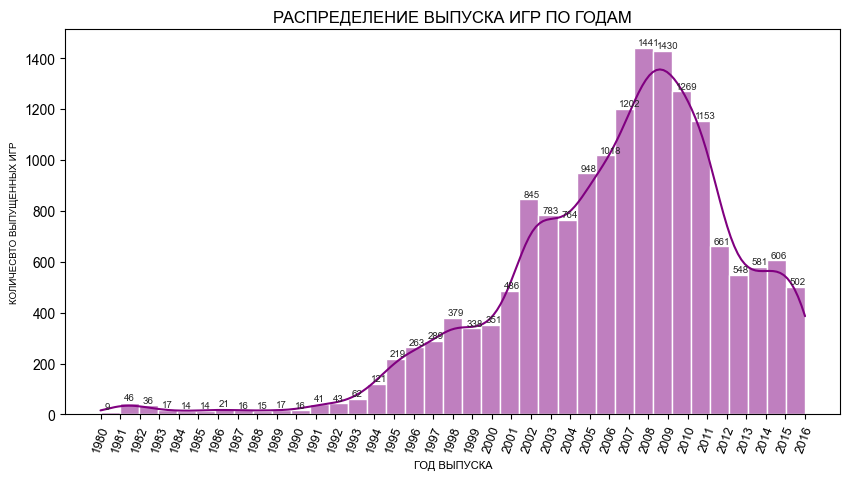

''

In [50]:
# формирую датасет, очищенный от отсутвующих значений года
data_years_clean = data.dropna(subset=['year_of_release'])

# строю диаграмму распределения
fig, ax = plt.subplots(figsize=(10,5))
sns.set(style="darkgrid")
sns.histplot(data=data_years_clean, x='year_of_release', kde=True, color="purple", bins = 37)
plt.xticks(range(1980, 2017))
plt.xticks(rotation=70, fontweight='light', fontsize = 9)
plt.title("РАСПРЕДЕЛЕНИЕ ВЫПУСКА ИГР ПО ГОДАМ", loc='center')
plt.xlabel('ГОД ВЫПУСКА', fontsize = 8)
plt.ylabel('КОЛИЧЕСВТО ВЫПУЩЕННЫХ ИГР', fontsize = 7)

# добавляю надписи на столбцах
#ax.bar_label(ax.containers[0], fontsize = 7)

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x()+0.2, p.get_height()+10), fontsize=7)

plt.show()    

;

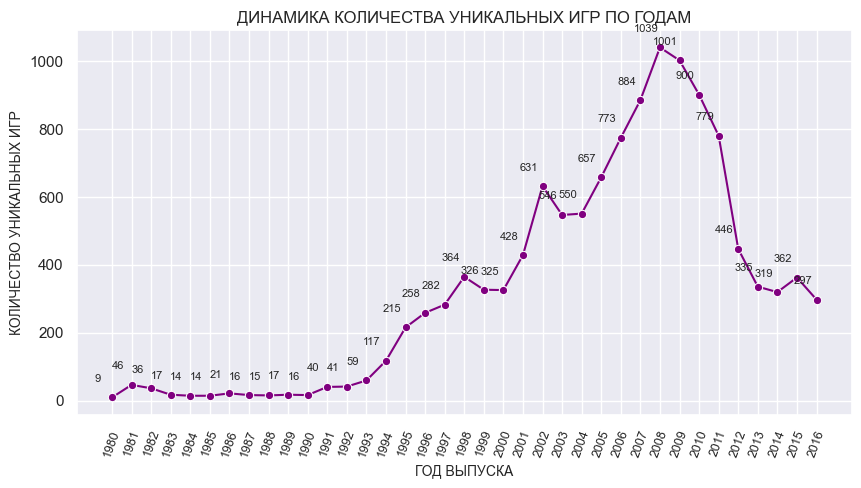

In [51]:
# создаю датасет с уникальными играми по годам
games_byear = data.groupby('year_of_release')['name'].nunique()

plt.figure(figsize=(10,5))
sns.lineplot(x=games_byear.index, y=games_byear.values, color='purple', marker = 'o')

plt.xticks(range(1980, 2017), rotation=70, fontweight='light', fontsize=9)
plt.title('ДИНАМИКА КОЛИЧЕСТВА УНИКАЛЬНЫХ ИГР ПО ГОДАМ', fontsize=12)
plt.xlabel('ГОД ВЫПУСКА', fontsize=10)
plt.ylabel('КОЛИЧЕСТВО УНИКАЛЬНЫХ ИГР', fontsize=10)

# добавляю подписи на график
for i, value in enumerate(games_byear.values):
    if i % 1 == 0:
        plt.annotate(str(value), xy=(games_byear.index[i], value), xytext=(-10, 10), textcoords='offset points', fontsize=8, ha='center', va='bottom')


plt.show()

#### ДОПОЛНИТЕЛЬНОЕ ПРОМЕЖУТОЧНОЕ НАБЛЮДЕНИЕ

График уникальных игр по годам фактически повторяет распределение всех игр по годам. Пик также приходится на 2008-2009 года с последующей достаточно резкой стагнацией  

''

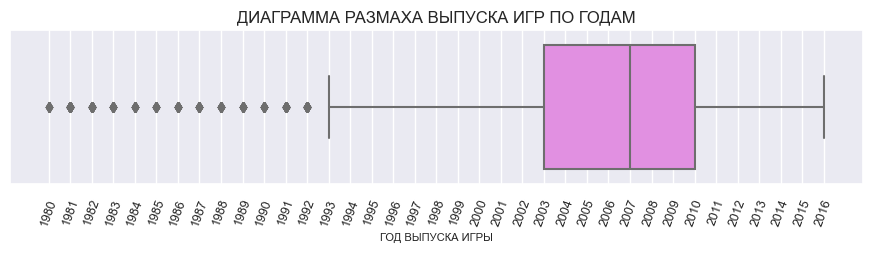

In [52]:
fig, ax = plt.subplots(figsize=(11,2))
sns.set(style="darkgrid")
sns.boxplot(data=data_years_clean, x='year_of_release', color="violet")
plt.xticks(range(1980, 2017))
plt.xticks(rotation=70, fontweight='light', fontsize = 9)
plt.title("ДИАГРАММА РАЗМАХА ВЫПУСКА ИГР ПО ГОДАМ", loc='center')
plt.xlabel('ГОД ВЫПУСКА ИГРЫ', fontsize = 8)
;

#### ПРОМЕЖУТОЧНЫЕ НАБЛЮДЕНИЯ

Гистограмма распределения сильно смещена вправо и наглядно показывает интуитивно понятную вещь - в первые 14 лет (с 1980 по 1994) выпускалось совсем немного игр, а **пик производства игрового контента пришелся на 2008-2009 года** с развитием и совершенствованием платформ, развитием интрнета, повышением доступности игрового оборудования для бОльшего круга людей.  

**Важны ли данные за все периоды?**

Для прогнозирования продаж игр на 2017 год данные за 1980-ые и 90-ые годы не важны, так как тогда были совсем другие и сами игры, и паттерны потребления игрового контента. Чтобы выбрать временной период я построила диаграмму размаха. **Предварительно можно говорить о том, что в исследовнии имеет смысл использовать данные начиная с третьего квартиля - 2008-2009 года**.

### Изменение продаж игр по платформам 

Для оценки изменения продаж игр по платформам:
- сначала оценю продажи игр по платформам в целом за весь временной период 
- затем отберу топ 10 платформ с наибольшими суммарными продажами также за все годы 
- после этого построю распределение для этих платформ по годам



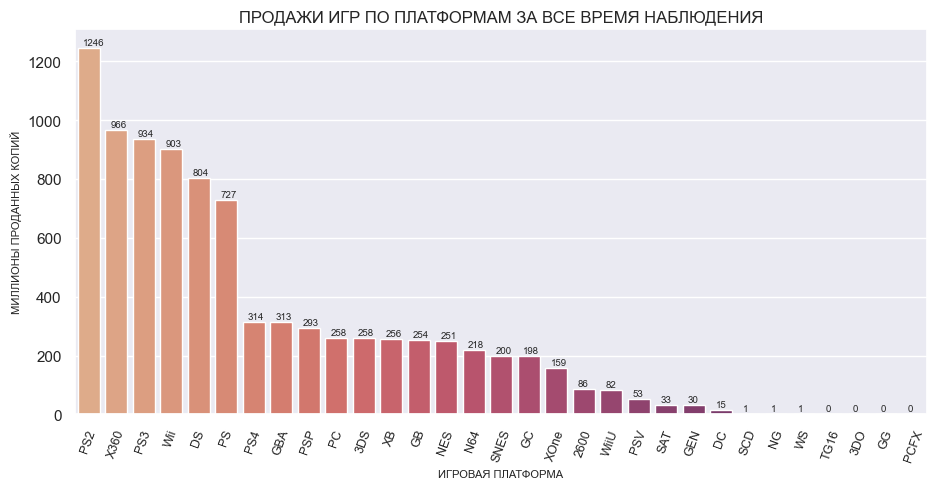

''

In [53]:
# я продолжаю использовать датасет, очищенный от пропусков в значении года, так как дальше мне нужно будет 
# строить распределение по годам для этих платформ

games_by_platforms_sales = data_years_clean.pivot_table(index=['platform'], values=['total_sales'], aggfunc = 'sum').reset_index().sort_values(by = "total_sales", ascending=False)

fig, ax = plt.subplots(figsize=(11,5))
sns.set(style="darkgrid")

sns.barplot(x=games_by_platforms_sales['platform'],y=games_by_platforms_sales['total_sales'], palette = 'flare')


plt.xticks(rotation=70, fontweight='light', fontsize = 9)
plt.title("ПРОДАЖИ ИГР ПО ПЛАТФОРМАМ ЗА ВСЕ ВРЕМЯ НАБЛЮДЕНИЯ", loc='center')
plt.xlabel('ИГРОВАЯ ПЛАТФОРМА', fontsize = 8)
plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 8)

# добавляю надписи на столбцах
#ax.bar_label(ax.containers[0], fontsize = 8, rotation=90)
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x()+0.2, p.get_height()+10), fontsize=7)

plt.show()    

;


Отберу ТОП 10 платформ-рекордсменов по продажам за все время наблюдения

In [54]:
games_by_platforms_sales.head(10)

,platform,total_sales
16,PS2,1246.21
28,X360,966.61
17,PS3,934.70
26,Wii,903.31
4,DS,804.28
15,PS,727.58
18,PS4,314.14
6,GBA,313.73
19,PSP,293.57
13,PC,258.86


In [55]:
# преобразую топовые платформы в список
top_platforms = games_by_platforms_sales.head(10)['platform'].tolist()

# cформирую выборку по топовым платформам и по годам для построения распределения
sales_by_year_and_platform = data_years_clean.loc[data_years_clean['platform'].isin(top_platforms)].pivot_table( 
                                             index='year_of_release', columns='platform', values='total_sales', aggfunc = 'sum')
sales_by_year_and_platform

platform,DS,GBA,PC,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1985.0,0.02,NaN,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988.0,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992.0,NaN,NaN,3.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994.0,NaN,NaN,12.87,6.03,NaN,NaN,NaN,NaN,NaN,NaN
1995.0,NaN,NaN,4.22,35.96,NaN,NaN,NaN,NaN,NaN,NaN
1996.0,NaN,NaN,10.58,94.70,NaN,NaN,NaN,NaN,NaN,NaN
1997.0,NaN,NaN,11.27,136.17,NaN,NaN,NaN,NaN,NaN,NaN
1998.0,NaN,NaN,3.26,169.49,NaN,NaN,NaN,NaN,NaN,NaN
1999.0,NaN,NaN,4.74,144.53,NaN,NaN,NaN,NaN,NaN,NaN


''

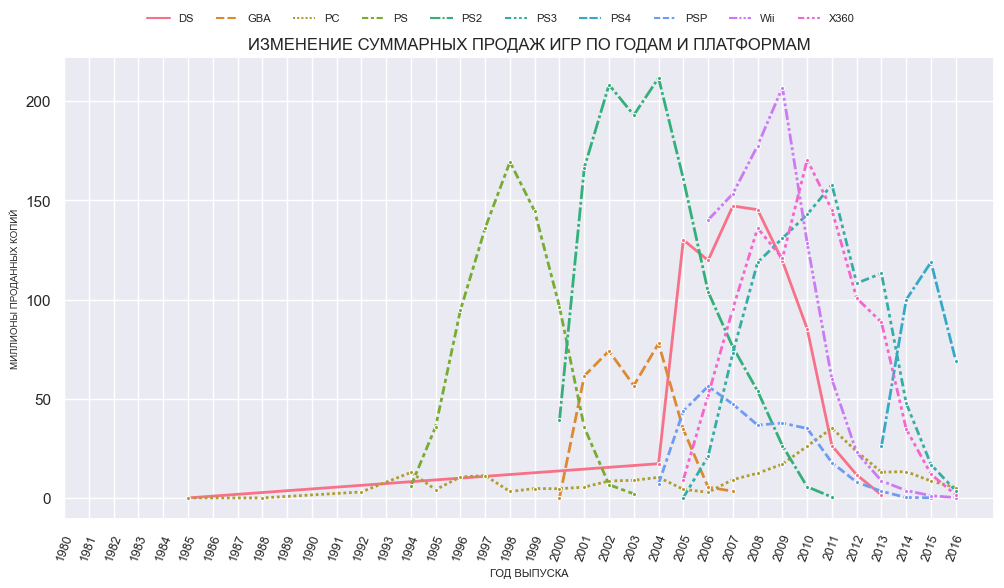

In [56]:
# строю график распределения топовых платформ по годам
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style("whitegrid")
sns.lineplot(
    data=sales_by_year_and_platform, palette = 'husl', marker=".", linewidth = 2
)

ax.legend(
    loc="lower center",
    bbox_to_anchor=(.47, 1.05),
    ncol=11,
    title=None,
    frameon=False,
    fontsize=8
)

plt.xticks(range(1980, 2017))
plt.xticks(rotation=70, fontweight='light', fontsize = 9)

plt.title("ИЗМЕНЕНИЕ СУММАРНЫХ ПРОДАЖ ИГР ПО ГОДАМ И ПЛАТФОРМАМ", loc='center')
plt.xlabel('ГОД ВЫПУСКА', fontsize = 8)
plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 7)
;

#### ПРОМЕЖУТОЧНЫЕ НАБЛЮДЕНИЯ

ТОП 10 платформ по суммарным продажам:
- **самой "кассовой" платформой** за весь период данных, представленных в датасете, является **PlayStation 2** 
- **второе место** по продажам занимает **Xbox 360**
- **третье место** по продажам занимает **PlayStation 3**
- **четвертое место** по продажам занимает **Nintendo Wii**
- **пятое место** по продажам занимает **Nintendo DS**
- **шестрое и седьмое место** по продажам занимают продукты PlayStation: **PlayStation и PlayStation 4**
- **восьмое место** по продажам занимает **Nintendo Game Boy Advance**
- **девятое место** по продажам занимает **PlayStation Portable**
- **десятое место** по продажам занимает **PC**

По графику изменения суммарных продаж для топовых игровых платформ можно сделать несколько выводов:
1. Продажи всех платформ имеют ниспадающий тренд во времени с обязательным пиком в первый год с момента появления. **К 2016 году все топовые платформы уже потеряли свою актуальность и продажи по ним находятся на своем минимуме**
2. **Характерный срок жизни** для платформ составляет **8 - 12 лет**

Отдельно хочу отметить, что:
- До 2000 года параллельно существовали всего 3 из всех топовых платформ, а после 2000 года их плотность значительно возрастает и параллельно может существовать до 7 платфом. Самая кассовая платформа PlayStation 2 появляется как раз в 2000 году.
- Отдельно стоит сказать о "долгожителе" PC, который хотя и существует с 1985 года до 2016 (и дальше), но все-таки не является именно игровой платформой (это все-таки многофункциональное устройство, а возможность играть на PC это "приятный бонус"). Этот вывод подтверждается тем, что продажи игр для PC резко падают в тот год, когда PlayStation - первыя полноценная игровая консоль - достигает максимума своих продаж. И дальше имеют ниспадающий тренд вплоть до 2016 года наблюдений 

### Определение актуального периода и формирование датасета для дальнейшего исследования

Задачей исследования является прогноз продаж игр на 2017 год, поэтому необходимо выбрать период, который будет отражать текущие тренды в игровой сфере.
1.  В предыдущих пунктах я определила, что пиком развития игровых платформ является 2008-2009 года, после чего рынок показывает сильную стагнацию и к 2016 находится в своей нижней точке
2. Время жизни игровых платформ 8-12 лет, соответственно нужно выбирать такой актуальный период, чтобы остаточный срок жизни платформ на 2016 год составлял еще несколько лет
3. Графики кол-ва игр по годам и изменения суммарных продаж по годам отлично иллюстрируют динамичность рынка игровых консолей. При таких быстрых и значительных изменениях как в этом случае нельзя брать большой актуальный период, он не позволит сделать качественный прогноз на 2017 год. 

Перспектива последних 2-3 лет является наиболее оптимальной для целевого прогноза. Так как данные за 2016 год не полные, необходимо брать последние 3 года для дальнейших исследований.  

**Таким образом, беру 2014 год как пороговый, он будет начальной точкой для формирования датасета для дальнейшего исследования**

In [57]:
a_data = data_years_clean.query('year_of_release >= 2014')
a_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,call of duty: black ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,grand theft auto v,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3DS,2014.0,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
77,fifa 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,star wars battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98


Проверяю, что в выборку попали нужные года

In [58]:
a_data['year_of_release'].sort_values().unique()

array([2014., 2015., 2016.])

Все ОК, можно переходить к дальнейшему исследованию.

### Определение платформ - лидеров по продажам

Для определения платформ - лидеров по продажам:
- сначала оценю продажи игр по платформам в целом за 2008 - 2016 годы
- после этого построю распределение для платформ по годам, чтобы оценить их динамику

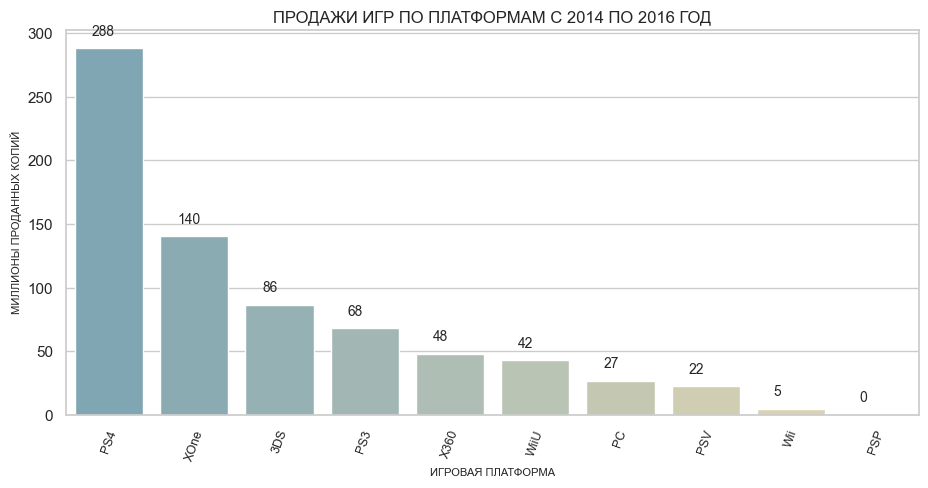

''

In [59]:
a_games_by_platforms_sales = a_data.pivot_table(index=['platform'], values=['total_sales'], aggfunc = 'sum').reset_index().sort_values(by = "total_sales", ascending=False)

fig, ax = plt.subplots(figsize=(11,5))
sns.set(style="darkgrid")

sns.barplot(x=a_games_by_platforms_sales['platform'],y=a_games_by_platforms_sales['total_sales'], palette = 'blend:#7AB,#EDA')


plt.xticks(rotation=70, fontweight='light', fontsize = 9)
plt.title("ПРОДАЖИ ИГР ПО ПЛАТФОРМАМ С 2014 ПО 2016 ГОД", loc='center')
plt.xlabel('ИГРОВАЯ ПЛАТФОРМА', fontsize = 8)
plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 8)


# добавляю надписи на столбцах
#ax.bar_label(ax.containers[0], fontsize = 8, rotation=90)
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x()+0.2, p.get_height()+10), fontsize=10)

plt.show() 


;


In [60]:
# преобразую платформы в список
platforms = a_games_by_platforms_sales['platform'].tolist()

# cформирую выборку по топовым платформам и по годам для построения распределения
a_sales_by_year_and_platform = a_data.loc[a_data['platform'].isin(platforms)].pivot_table( 
                                             index='year_of_release', columns='platform', values='total_sales', aggfunc = 'sum')
a_sales_by_year_and_platform

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,
2014.0,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015.0,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016.0,15.14,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


''

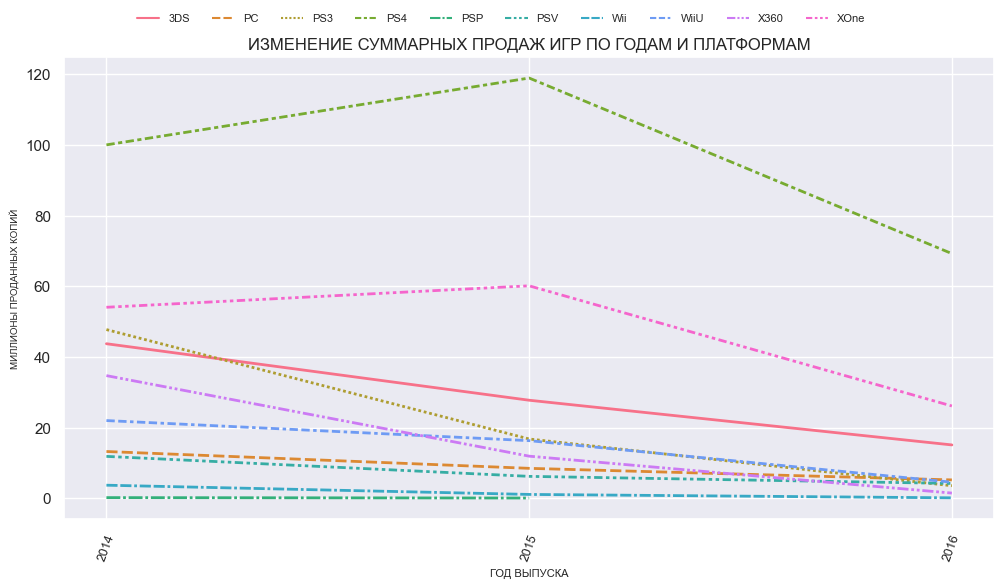

In [61]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style("whitegrid")
sns.lineplot(
    data=a_sales_by_year_and_platform, palette = 'husl', linewidth = 2
)

ax.legend(
    loc="lower center",
    bbox_to_anchor=(.47, 1.05),
    ncol=11,
    title=None,
    frameon=False,
    fontsize=8
)

plt.xticks(range(2014, 2017))
plt.xticks(rotation=70, fontweight='light', fontsize = 9)

plt.title("ИЗМЕНЕНИЕ СУММАРНЫХ ПРОДАЖ ИГР ПО ГОДАМ И ПЛАТФОРМАМ", loc='center')
plt.xlabel('ГОД ВЫПУСКА', fontsize = 8)
plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 7)
;

#### ПРОМЕЖУТОЧНЫЕ НАБЛЮДЕНИЯ

ТОП 10 платформ - лидеров по продажам в период с 2014 по 2016 год:
- **самой "кассовой" платформой** за этот период является **PlayStation 4** 
- **второе место** по продажам занимает **Xbox One**
- **третье место** по продажам занимает **Nintendo 3DS**
- **четвертое место** по продажам занимает **PlayStation 3**
- **пятое место** по продажам занимает **Xbox 360**
- **шестое место** по продажам занимает **Nintendo WiiU**
- **седьмое место** по продажам занимает **Microsoft PC**
- **восьмое место** по продажам занимает **PlayStation Vita**
- **девятое место** по продажам занимает **Nintendo Wii**
- **десятое место** по продажам занимает **PlayStation Portable**


Такое расположение игр в топе выглядит достаточно логично: первые две строчки занимают извечные конкуренты Sony и Microsoft. При этом PlayStation 4 лидирует с разгромным отрывом. Примечательно, что в трехлетнем топе на 4 и 5 строчке снова оказываются Sony и Microsoft со своими предыдущими хитами PlayStation 3 и Xbox 360. Nintendo также занимает 2 строчки в рейтинге - второе и шестое место. 


<a id="here"></a>

**При выборе потенциально прибыльных платформ я считаю правильным руководствоваться "принципом новизны"** и ориентироваться на последние модели платформ, которые показывают лучшие продажи на протяжении последних 3 лет. Эти платформы имеют больше шансов реализовать свой потенциал на протяжении следующих нескольких лет. Также, производители игр будут ориенироваться на них при выпуске нового контента. А цена платформ для потребителя будет становиться все более доступной, и они будут становиться более массовыми моделями, заменяя старые консоли.


*[вернуться обратно в портреты](#prt)*

#### ИТОГО - финальный список потенциально наиболее прибыльных платформ на основе продаж за последние 3 года (2014-2016) и принципа новизны: 
1. PlayStation 4 (год выпуска 2013)
2. XBox One (год выпуска 2013)
3. Nintendo 3DS (год выпуска 2011)
4. Nintendo Wii U (год выпуска 2012)
5. PlayStation Vita (год выпуска 2011)

### Диаграмма размаха по глобальным продажам игр в разбивке по платформам

Для построения диаграммы сохраню названия отобранных платформ в переменную top_5_platforms

In [63]:
top_5_platforms = ['PS4', 'XOne', '3DS', 'WiiU', 'PSV']

Собираю полный датасет на основе a_data, ограниченной с 2014 по 2016 года, где собраны все данные по ТОП 5 платформ

In [65]:
top_5_platforms_sales = a_data.query('platform == "PS4" or platform == "XOne" or platform == "3DS" or platform == "WiiU" or platform == "PSV"')

#проверяю, что отобраны только нужные платформы
top_5_platforms_sales['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU', 'PSV'], dtype=object)

Можно строить диаграмму размаха

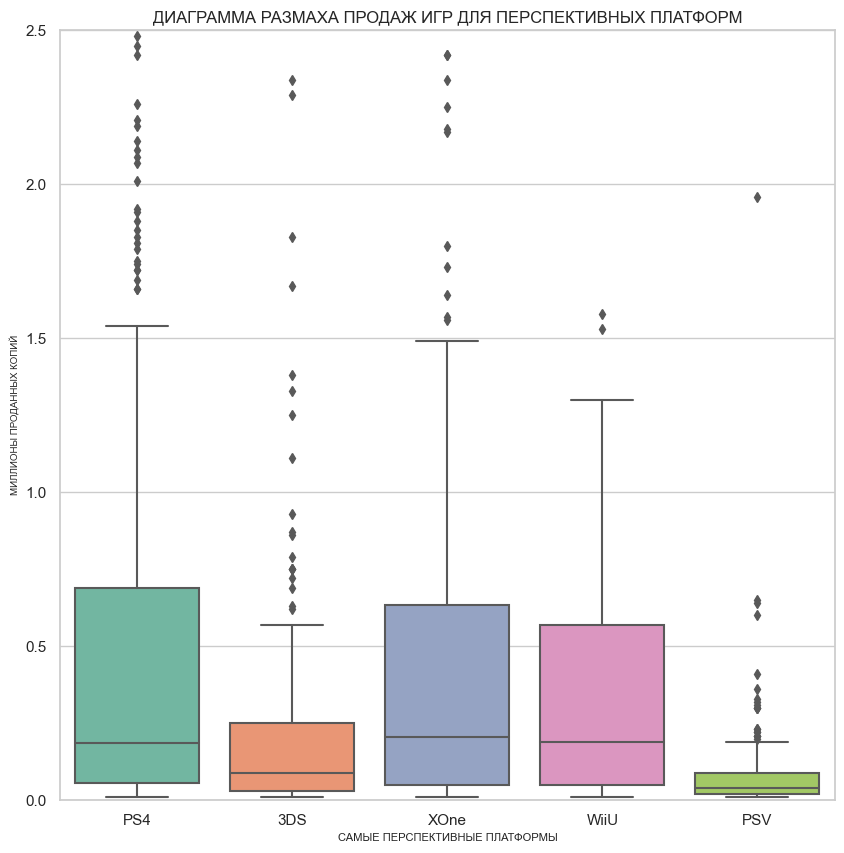

''

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style("whitegrid")
sns.boxplot(data=top_5_platforms_sales, x='platform', y='total_sales', palette = 'Set2')
ax.set_ylim(0, 2.5) # из-за больших выбросов у 3DS и PS4 меняю масштаба оси Y, чтобы были видны ящики
plt.title("ДИАГРАММА РАЗМАХА ПРОДАЖ ИГР ДЛЯ ПЕРСПЕКТИВНЫХ ПЛАТФОРМ", loc='center')
plt.xlabel('САМЫЕ ПЕРСПЕКТИВНЫЕ ПЛАТФОРМЫ', fontsize = 8)
plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 7)
plt.show()
;

In [67]:
top_5_platforms_sales.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
PSV,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96
WiiU,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
XOne,228.0,0.615614,1.046513,0.01,0.0500,0.205,0.6325,7.39


#### ПРОМЕЖУТОЧНЫЕ НАБЛЮДЕНИЯ

- Медианы продаж PlayStation 4, XBox One и Nintendo Wii U очень близки 
- Безусловными **лидером по продажам** является **PlayStation 4** - 1 место. Это достаточно логичный результат - консоль является последнией моделью у Sony. 
- **XBox One** занимает 2 место по продажам - тоже закономерный результат вечного дерби между Microsoft и Sony, в которой первые проигрывают год за годом *(все перепетии [тут](https://www.igromania.ru/article/31445/PS4_protiv_Xbox_One._Kak_Sony_pereigrala_Microsoft.html))*
- **Nintendo Wii U** занимает 3 место по продажам. Это самая новая на момент исследования модель японского производителя и единственный конкурент классическим консолям от Sony и Microsoft.
> Отличительной особенностью Wii U являлся новый контроллер, который мог использоваться как дополнительный сенсорный экран, что позволяло игроку получать новые игровые ощущения, а в некоторых играх он мог частично заменить телевизор, играя через GamePad. При этом игры с предыдущего поколения Wii были не совместимы с новой моделью U :)
>
> Последнее может объяснить почему перспективная платформа за 5 лет на рынке не сумела догнать своих главных конкурентов. 
>
> *Лирическое отступление: после Wii U в 2017 прогнозном для нас году Nintendo выпустил мой обожаемый Switch и дело пошло на лад :)* 
- **Nintendo 3DS** занимает 4 место по продажам, а **PlayStation Vita** 5 место по продажам. Это две носимые консоли в топе и можно отметить интерес к этому формату о потрбителей, но очевидно, что формат приставок пока несовершенный и по продажам они сильно уступают классическим консолям.

### Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков

Рассмотрим влияние отзывов пользователей и критиков на продажи на примере лидера рынка - PlayStation 4.

В первую очередь необходимо собрать 2 датасета для анализа - исключить все строки, где оценки критиков и пользователей являются NaN.

In [68]:
a_data_clean_cs = a_data.dropna(subset=['critic_score'])
a_data_clean_cs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, 42 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             718 non-null    object 
 1   platform         718 non-null    object 
 2   year_of_release  718 non-null    float64
 3   genre            718 non-null    object 
 4   na_sales         718 non-null    float64
 5   eu_sales         718 non-null    float64
 6   jp_sales         718 non-null    float64
 7   other_sales      718 non-null    float64
 8   critic_score     718 non-null    float64
 9   user_score       704 non-null    float64
 10  rating           718 non-null    object 
 11  total_sales      718 non-null    float64
dtypes: float64(8), object(4)
memory usage: 72.9+ KB


In [69]:
a_data_clean_us = a_data.dropna(subset=['user_score'])
a_data_clean_us.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 42 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             888 non-null    object 
 1   platform         888 non-null    object 
 2   year_of_release  888 non-null    float64
 3   genre            888 non-null    object 
 4   na_sales         888 non-null    float64
 5   eu_sales         888 non-null    float64
 6   jp_sales         888 non-null    float64
 7   other_sales      888 non-null    float64
 8   critic_score     704 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           888 non-null    object 
 11  total_sales      888 non-null    float64
dtypes: float64(8), object(4)
memory usage: 90.2+ KB


#### ВЛИЯНИЕ ОЦЕНОК ПОЛЬЗОВАТЕЛЕЙ НА ПРОДАЖИ ИГР ДЛЯ PS4

Собираю в переменную данные, относящиеся к PlayStation 4 по очищенному датасету с оценками пользователей

In [70]:
platform_name = 'PS4'
platform = a_data_clean_us[a_data_clean_us['platform'] == platform_name]
platform.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,grand theft auto v,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,fifa 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
92,call of duty: advanced warfare,PS4,2014.0,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,fifa 17,PS4,2016.0,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,fallout 4,PS4,2015.0,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17


In [71]:
display("Корреляция между отзывами пользователей и продажами: {0:.4f}".format(platform['user_score'].corr(platform['total_sales'])))

'Корреляция между отзывами пользователей и продажами: -0.0401'

''

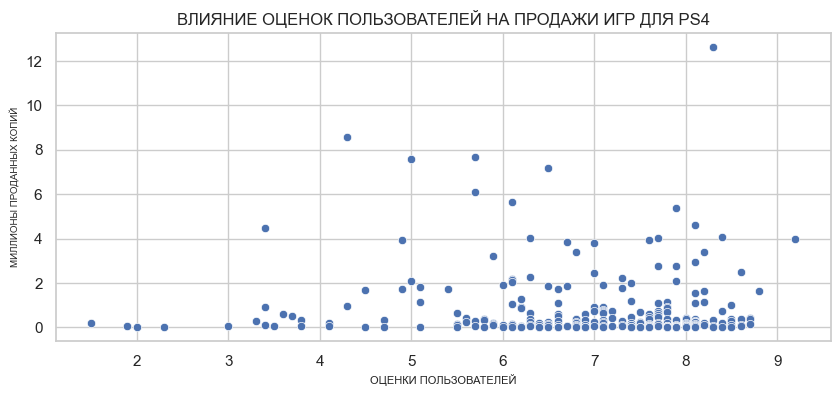

In [72]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set_style("whitegrid")
sns.scatterplot(x='user_score', y='total_sales', data=platform)
plt.title("ВЛИЯНИЕ ОЦЕНОК ПОЛЬЗОВАТЕЛЕЙ НА ПРОДАЖИ ИГР ДЛЯ PS4", loc='center')
plt.xlabel('ОЦЕНКИ ПОЛЬЗОВАТЕЛЕЙ', fontsize = 8)
plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 7)
;

#### ВЛИЯНИЕ ОЦЕНОК КРИТИКОВ НА ПРОДАЖИ ИГР ДЛЯ PS4

Собираю в переменную данные, относящиеся к PlayStation 4 по очищенному датасету с оценками критиков

In [73]:
platform_name = 'PS4'
platform = a_data_clean_cs[a_data_clean_cs['platform'] == platform_name]
platform.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,grand theft auto v,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,fifa 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
92,call of duty: advanced warfare,PS4,2014.0,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,fifa 17,PS4,2016.0,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,fallout 4,PS4,2015.0,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17


In [74]:
display("Корреляция между отзывами критиков и продажами: {0:.4f}".format(platform['critic_score'].corr(platform['total_sales'])))

'Корреляция между отзывами критиков и продажами: 0.4027'

''

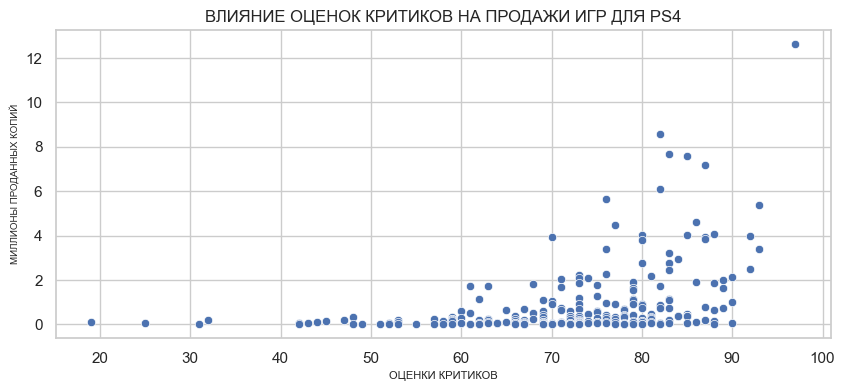

In [75]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set_style("whitegrid")
sns.scatterplot(x='critic_score', y='total_sales', data=platform)
plt.title("ВЛИЯНИЕ ОЦЕНОК КРИТИКОВ НА ПРОДАЖИ ИГР ДЛЯ PS4", loc='center')
plt.xlabel('ОЦЕНКИ КРИТИКОВ', fontsize = 8)
plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 7)
;

#### ПРОМЕЖУТОЧНЫЕ НАБЛЮДЕНИЯ

**PlayStation 4**

**Корреляция между отзывами пользователей и продажами составляет -0.0401**

Можно говорить о том, что между этими двумя переменными есть очень слабая обратная связь. Так как значение корреляции близко к нулю, то можно предположить, что изменения в одной переменной почти не влияют на изменения другой переменной. 

> Другими словами,
> **оценки пользователей почти не влияют на продажи игр на платформе PS4**. При этом диаграмма рассеяния показывает, что и у игр с оценками от 3 до 5 могут быть высокие продажи.  


**Корреляция между отзывами критиков и продажами составляет 0.4027**

Можно говорить о том, что существует умеренная положительная корреляционная связь между этими двумя переменными. Можно говорить о том, что изменения в одной переменной будут влиять на изменения в другой переменной.

> Другими словами,
> **оценки критиков умеренно влияют на продажи игр на платформе PS4**. Так, игры, получившие более высокие оценки критиков, склонны иметь более высокие продажи, а игры, получившие более низкие оценки, склонны иметь более низкие продажи. Диаграмма рассеяния подтверждает этот вывод: заметное количество игр с выделяющимеся высокими продажами начинается от рейтинга 70+

### Соотнесу эти наблюдения с продажами игр на других платформах

'3DS'

'Корреляция между отзывами пользователей и продажами: 0.2152'

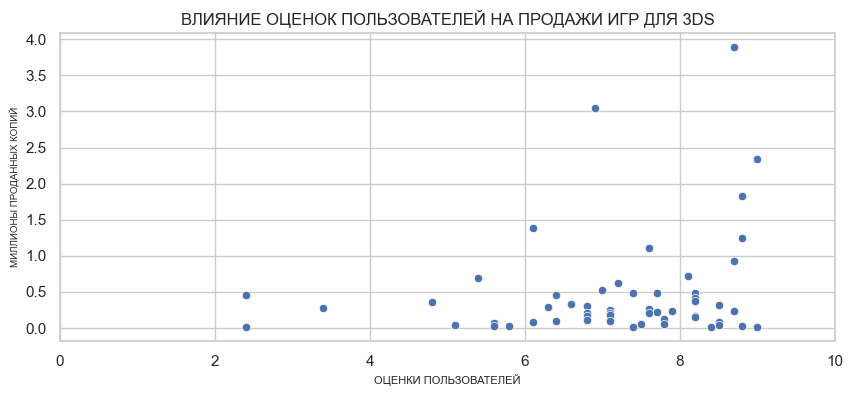

'Корреляция между отзывами критиков и продажами: 0.3141'

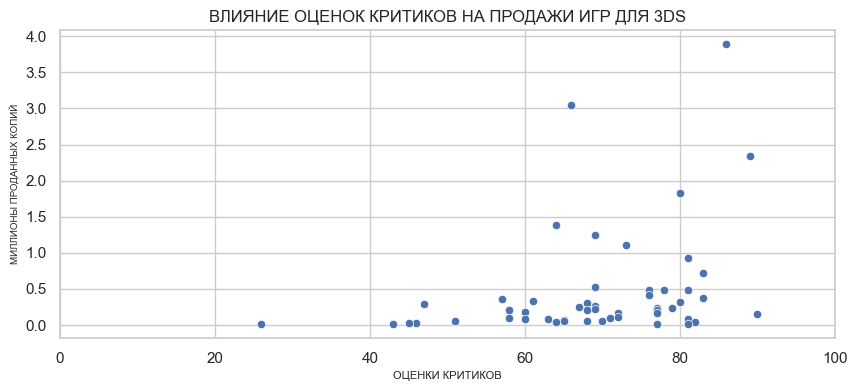

'WiiU'

'Корреляция между отзывами пользователей и продажами: 0.4079'

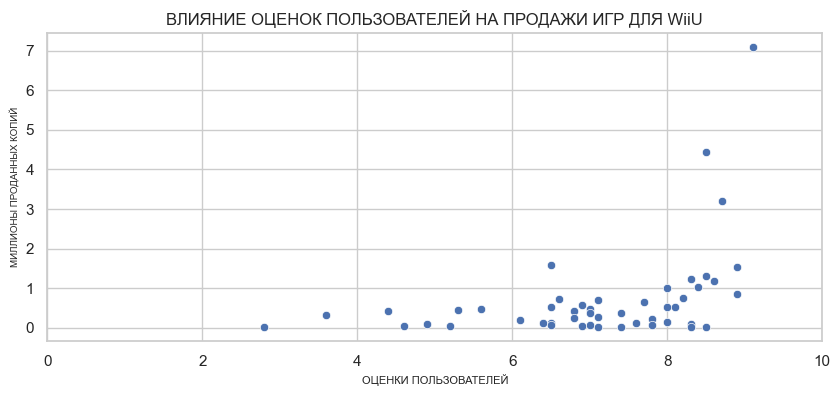

'Корреляция между отзывами критиков и продажами: 0.3702'

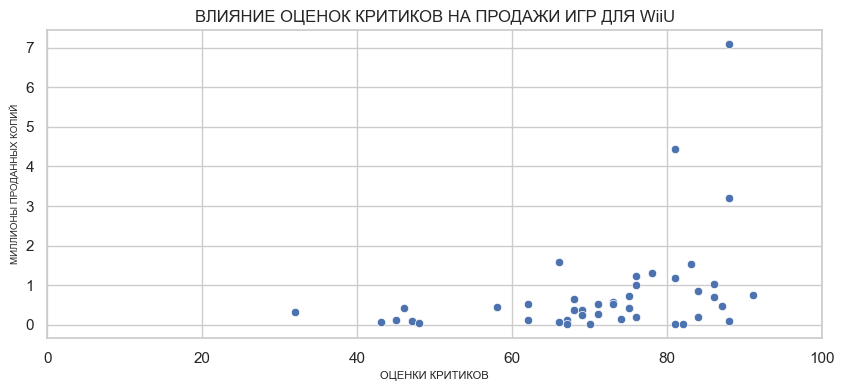

'XOne'

'Корреляция между отзывами пользователей и продажами: -0.0704'

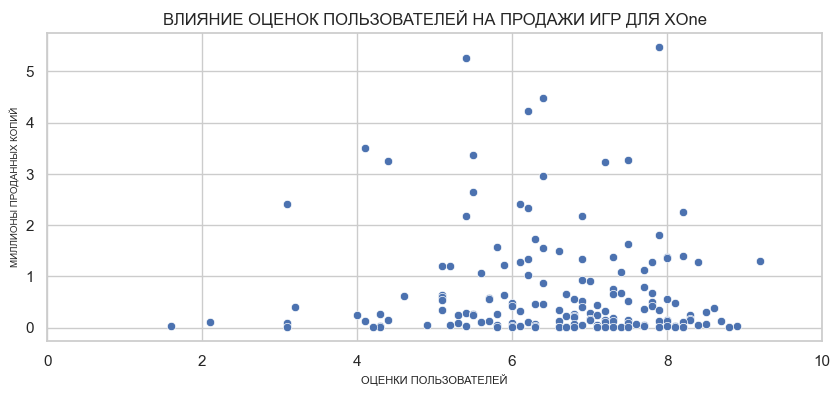

'Корреляция между отзывами критиков и продажами: 0.4287'

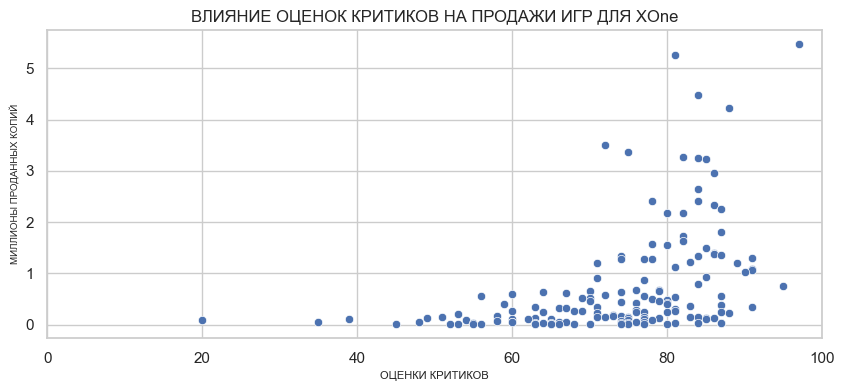

'PSV'

'Корреляция между отзывами пользователей и продажами: -0.1685'

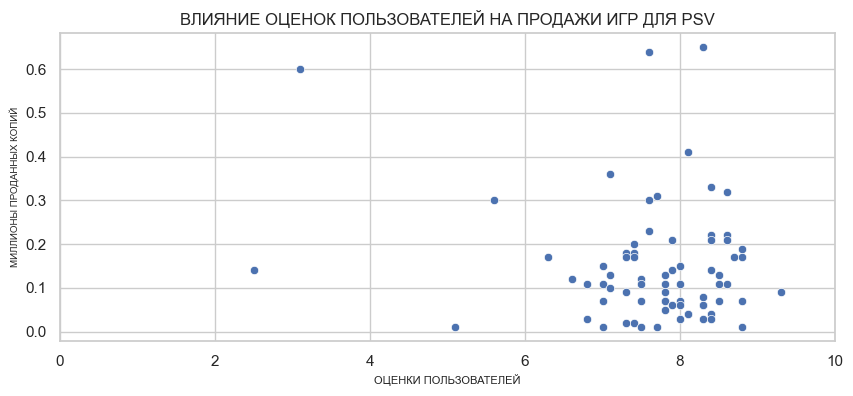

'Корреляция между отзывами критиков и продажами: 0.0427'

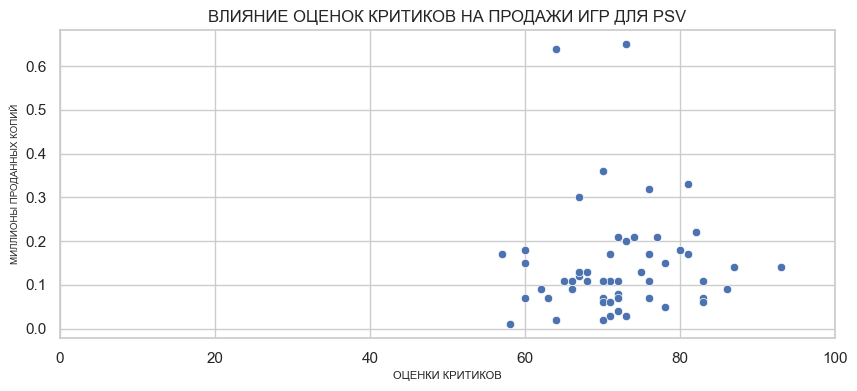

In [76]:
platform_list = ['3DS', 'WiiU', 'XOne', 'PSV']

for platform_name in platform_list:
    platform_us = a_data_clean_us[a_data_clean_us['platform'] == platform_name]
    platform_cs = a_data_clean_cs[a_data_clean_cs['platform'] == platform_name]

    display(platform_name)
    
    # корреляция пользователь - продажи
    display("Корреляция между отзывами пользователей и продажами: {0:.4f}".format(platform_us['user_score'].corr(platform_us['total_sales'])))
    # график рассеяния пользователь - продажи
    fig, ax = plt.subplots(figsize=(10,4))
    sns.set_style("whitegrid")
    sns.scatterplot(x='user_score', y='total_sales', data=platform_us)
    ax.set_xlim([0, 10])
    plt.title(f"ВЛИЯНИЕ ОЦЕНОК ПОЛЬЗОВАТЕЛЕЙ НА ПРОДАЖИ ИГР ДЛЯ {platform_name}", loc='center')
    plt.xlabel('ОЦЕНКИ ПОЛЬЗОВАТЕЛЕЙ', fontsize = 8)
    plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 7)
    plt.show()
    
    # корреляция критик - продажи
    display("Корреляция между отзывами критиков и продажами: {0:.4f}".format(platform_cs['critic_score'].corr(platform_cs['total_sales'])))
    # график рассеяния критик - продажи
    fig, ax = plt.subplots(figsize=(10,4))
    ax.set_xlim([0, 100])
    sns.set_style("whitegrid")
    sns.scatterplot(x='critic_score', y='total_sales', data=platform_cs)
    plt.title(f"ВЛИЯНИЕ ОЦЕНОК КРИТИКОВ НА ПРОДАЖИ ИГР ДЛЯ {platform_name}", loc='center')
    plt.xlabel('ОЦЕНКИ КРИТИКОВ', fontsize = 8)
    plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 7)
    plt.show()

#### ПРОМЕЖУТОЧНЫЕ НАБЛЮДЕНИЯ

**ВЛИЯНИЕ ОЦЕНОК ПОЛЬЗОВАТЕЛЕЙ НА ПРОДАЖИ ИГР**

>**3DS** Корреляция между отзывами пользователей и продажами составляет 0.2152
>
>**WiiU** Корреляция между отзывами пользователей и продажами составляет 0.4079
>
>**XOne** Корреляция между отзывами пользователей и продажами составляет -0.0704
>
>**PSV** Корреляция между отзывами пользователей и продажами составляет  -0.1685


**ВЛИЯНИЕ ОЦЕНОК КРИТИКОВ НА ПРОДАЖИ ИГР**

>**3DS** Корреляция между отзывами критиков и продажами составляет 0.3141
>
>**WiiU** Корреляция между отзывами критиков и продажами составляет 0.3702
>
>**XOne** Корреляция между отзывами критиков и продажами составляет 0.4287
>
>**PSV** Корреляция между отзывами критиков и продажами составляет  0.0427

**Анализ показывает, что принципы, выведенные при анализе PS4 применимы только к ее прямому конкуренту XBox One.** 
- так, оценки пользователей почти не влияют на продажи игр на платформе XBox One (обратная корреляция близкая к 0 -- -0.0704)
- а оценки критиков оказывают умеренное влияние на продажи игр на этой платформе (показатель 0.4287).

**Другую картину показывают оба продукта Nintendo**:
- оценки пользователей умеренно влияют и на продажи 3DS, и на продажи WiiU (0.2152 и 0.4079). При этом пользователи WiiU сильнее ориентируются на оценки других игроков, чем пользователи 3DS
- оценки критиков тоже умеренно влияют и на продажи 3DS, и на продажи WiiU (0.3141 и 0.3702). При этом значение близкое для обеих платформ. 

**Отдельно стоит вторая носимая платформа в ТОПе PlayStation Vita**:
- она демонстрирует очень слабую обратную связь между оценками пользователй и продажами -0.1685 и слабую связь между оценками критиков и продажами 0.0427
- таким образом можно говорить, что ни оценки критиков, ни оценки пользователей не оказывают заметного влияния на продажи на этой платформе

**Говоря об общем тренде можно сделать вывод, что в целом оценки критиков значительно важнее для пользователей, чем оценки других игроков**.

Платформы Nintendo стоят отдельно, так как являются более нишевым продуктом по сравнению с лидерами рынка Sony и Microsoft, на них скорее всего выпускается гораздо меньше игр, поэтому: 
- с одной стороны, критики наверняка не так охотно пишут на них обзоры
- у пользователей скорее всего сильное комьюнити, и они с удовольствием пишут обзоры

**Носимая консоль Sony - самый нишевый продукт в ТОПе.** В свое время они проиграли конкуренцию продуктам Nintendo, сама компания Sony сфокусировалась на развитии своего флагмана PS4, перестала выпускать для PSV эксклюзивные игры, которые больше всего раскрывали ее основное конкурентное преимущество - игры с AR. Зато компания стала активнее сотрудничать с разработчиками небольших игр. Издатель упростил процесс лицензирования для своего цифрового магазина, благодаря чему PS Vita обзавелась обширной библиотекой инди-хитов. Это полностью объясняет такое влияние (вернее его отсутствие) оценок пользователей и критиков. Инди-игры - это можно сказать авторские высказывания, и только на личном опыте можно понять зайдет тебе игра или нет.

### Общее распределение игр по жанрам

*Для анализа распределения игр по жанрам я буду использовать датасет a_data, отфильтрованный по актуальному временному периоду, так как эта информация будет использована в прогнозировании на 2017 год*

In [77]:
games_by_genre = a_data.pivot_table(index=['genre'], values=['name'], aggfunc = 'count').reset_index().sort_values(by = "name", ascending=False)
games_by_genre

,genre,name
0,Action,619
7,Role-Playing,221
1,Adventure,185
10,Sports,161
8,Shooter,128
3,Misc,113
6,Racing,69
2,Fighting,60
9,Simulation,44
4,Platform,38


''

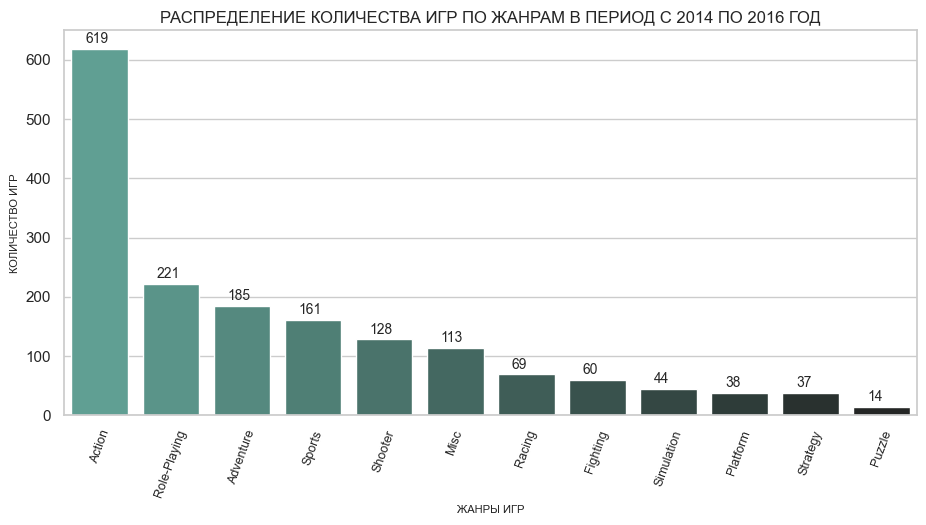

In [78]:
fig, ax = plt.subplots(figsize=(11,5))
sns.set(style="darkgrid")

sns.barplot(x=games_by_genre['genre'],y=games_by_genre['name'], palette = 'dark:#5A9_r')

plt.xticks(rotation=70, fontweight='light', fontsize = 9)
plt.title("РАСПРЕДЕЛЕНИЕ КОЛИЧЕСТВА ИГР ПО ЖАНРАМ В ПЕРИОД С 2014 ПО 2016 ГОД", loc='center')
plt.xlabel('ЖАНРЫ ИГР', fontsize = 8)
plt.ylabel('КОЛИЧЕСТВО ИГР', fontsize = 8)

# добавляю надписи на столбцах
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x()+0.2, p.get_height()+10), fontsize=10)

;

In [79]:
genre_sales = a_data.pivot_table(index=['genre'], values=['total_sales'], aggfunc = 'sum').reset_index().sort_values(by = "total_sales", ascending=False)
genre_sales

,genre,total_sales
0,Action,199.36
8,Shooter,170.94
10,Sports,109.48
7,Role-Playing,101.44
3,Misc,37.55
2,Fighting,28.22
6,Racing,27.52
4,Platform,18.09
1,Adventure,17.55
9,Simulation,13.13


''

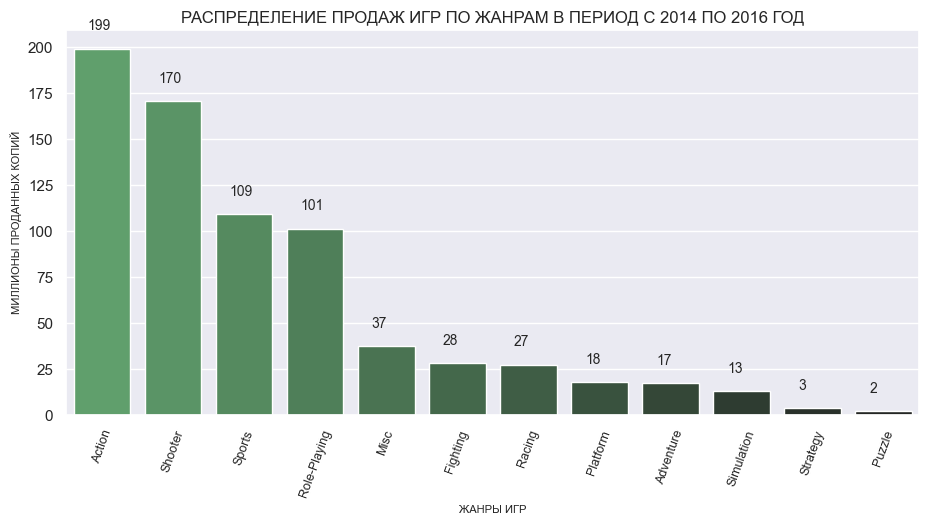

In [80]:
fig, ax = plt.subplots(figsize=(11,5))
sns.set(style="darkgrid")

sns.barplot(x=genre_sales['genre'],y=genre_sales['total_sales'], palette = 'dark:#5A6_r')

plt.xticks(rotation=70, fontweight='light', fontsize = 9)
plt.title("РАСПРЕДЕЛЕНИЕ ПРОДАЖ ИГР ПО ЖАНРАМ В ПЕРИОД С 2014 ПО 2016 ГОД", loc='center')
plt.xlabel('ЖАНРЫ ИГР', fontsize = 8)
plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 8)

# добавляю надписи на столбцах
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x()+0.2, p.get_height()+10), fontsize=10)

;

**ЛОГИКА ОПРЕДЕЛЕНИЯ НАИБОЛЕЕ ПЕРСПЕКТИВНЫХ ЖАНРОВ**

При выбоое игр на 2017 год нужно сделовать стратегии деверсификации - другими словами, строить портфель закупаемых игр таким образом, чтобы 
- точно заработать на играх, которые уверенно продадутся (из жанров с медианой на среднем уровне относительно других и относительно небольшими выбросами)
- инвестировать в высокорисковые жанры, ориентируясь на их популярность, прогнозы критиков и инсайдеров рынка, чтобы заработать на будущих "звездах" 2017 года (такие жанры будут иметь "высокую" медиану + сравнительно большие выбросы вверх)

Для определения этих показателей построю диаграмму размаха

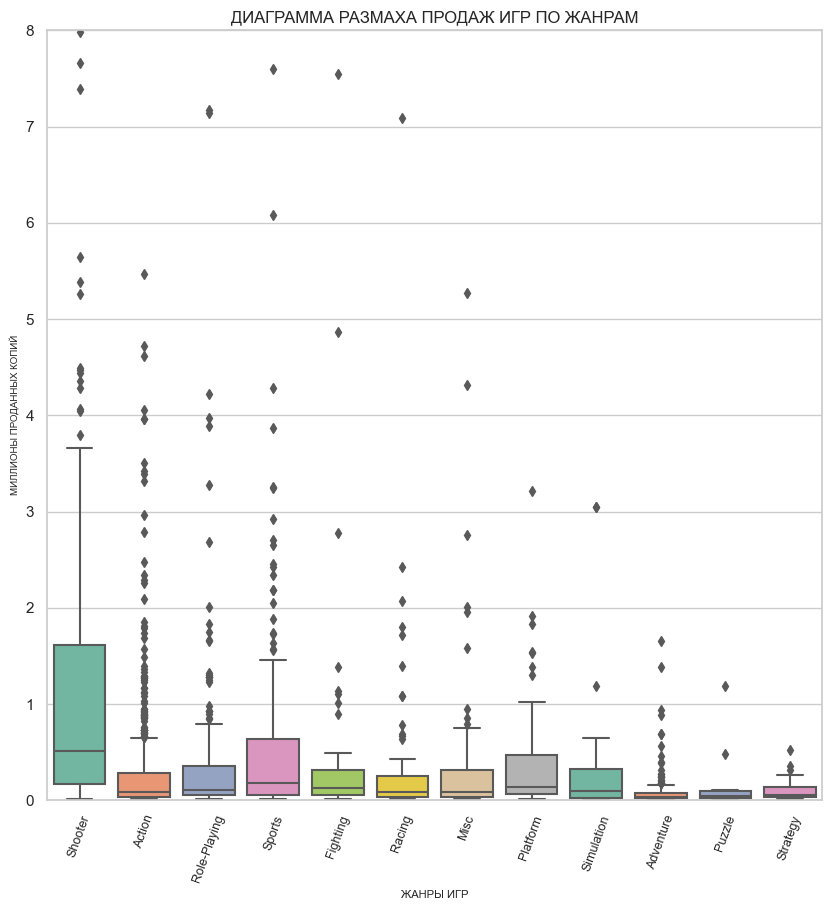

''

In [111]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_style("whitegrid")
sns.boxplot(data=a_data, x='genre', y='total_sales', palette = 'Set2')
ax.set_ylim(0, 8) 
plt.xticks(rotation=70, fontweight='light', fontsize = 9)
plt.title("ДИАГРАММА РАЗМАХА ПРОДАЖ ИГР ПО ЖАНРАМ", loc='center')
plt.xlabel('ЖАНРЫ ИГР', fontsize = 8)
plt.ylabel('МИЛЛИОНЫ ПРОДАННЫХ КОПИЙ', fontsize = 7)
plt.show()
;

#### ПРОМЕЖУТОЧНЫЕ НАБЛЮДЕНИЯ

**ТОП 5 жанров по количеству выпущенных игр в период с 2014 по 2016 года**:
1. Action (619 игр)	
2. Role-Playing (221 игр)	
3. Adventure (185 игр)	
4. Sports (161 игр)	
5. Shooter (128 игр)	

**ТОП 5 жанров по продажам в период с 2014 по 2016 года**

1. Action (199 млн проданных копий)	
2. Shooter (170 млн проданных копий)	
3. Sports (109 млн проданных копий)	
4. Role-Playing (101 млн проданных копий)	
5. Misc	(37 млн проданных копий) 

**Самые популярные жанры не равно самые выпускаемые, но есть безусловный лидер** 
- игры в жанре Action занимают первую строчку как по продажам, так и по количеству выпущенных игр
- Shooter находятся на последнем месте ТОП 5 по количеству выпускаемых игр, но занимают вторую строчку по продажам
- Sports игры находятся на третьем месте по продажам, но четвертом по выпущенным единицам
- Role-Playing занимают четвертую строчку по продажам, но вторую по количеству выпущенных игр
- музыкальные игры не вродят в ТОП 5 по количеству выпущенных единиц, но находятся на пятом месте по продажам

> Популярность игр в жанре экшн и шутеров можно объяснить большой свободой, которую эти жанры дают как игрокам, так и разработчикам: большое количество различных сеттингов (основанных на реальных событиях или полностью выдуманных), среди которых каждый может найти то, что ему нравится; высокие возможности по взаимодейстрию и коллаборации между игрками в онлайне - все это выводит эти жанры в ТОП. 
>
> Музыкальные игры тоже достаточно логично себя ведут. Их сложно и дорого производить, поэтому их немного. Но люди любят играть и петь :)

**При этом можно выделить безусловные жанры-"аутсайдеры"**:
- игры в жанре пазл находятся на последней строчке и по продажам и по количеству выпущенных игр (12 место)
- рядом с ними стоят игры в жанре стратегии - предпоследнее место по продажам и по выпуску игр (11 место)

> *Отступление с данными из "будущего"*
>
> *Если с жанром пазл все понятно, то угасание жанра стратегии происходит на протяжении последних двух десятилетий (10-20 годы), игр выпускается все меньше и они чаще всего являются переизданием "классики". Хотя даже в этой ситуации случаются провалы - Warcraft считается культовой игрой с огромной армия поклонников, но ее переиздание Warcraft III: Reforged (2020 год) получила очень низкие оценки как критиков, так и игроков и создателей игры даже обвиняли в том, что они решили нажиться на фанатах и их любви к оригинальному игровому миру*

**АНАЛИЗ ДИАГРАММЫ РАЗМАХА И РЕКОМЕНДАЦИИ ПО ПЕРСПЕКТИВНЫМ ЖАНРАМ**

**Жанры, на которых мы точно заработаем** (с медианой на среднем уровне относительно других и небольшими выбросами):
1. Fighting - медиана близка к среднему
2. Sports - медиана чуть ниже среднего
3. Role-Playing - медиана чуть ниже среднего
4. Music - медиана чуть ниже среднего
5. Racing - медиана чуть ниже среднего

Все они имеют достаточно близкую к среднему медиану, относительно невысокие выборсы, а также 4 из 5 входят в топ по количеству выпускаемых игр и по совокупным продажам. Другими словами, эти жанры популярны, в них выпускается достаточное количество игр (так жанр Platform не берем именно по этому признаку), но при этом их продажи сравнительно консистентны.

**Жанры, в которые мы инвестируем, надеясь попасть в звезды 2017 года** (с медианой на высоком уровне относительно других и/или значительными выбросами):
- Shooter
- Action

Здесь, хотя эти жанры находятся в ТОПах по кличеству и по продажам, у Shooter-ов медиана очень высокая и выбросы самые большие, а у жанра Action хотя и среднее значение медианы, но тоже очень значительные выбросы. В обоих жанрах выпускается много игр, но очевидно, что в обоих бывают игры-звезды, которые делают кассу, и проходные пустышки. Поэтому закупать игры нужно ориентируясь на дополнительные исследования (прогнозы критиков, анализ пользовательского сообщества (что больше ждут), экспертный анализ)

<a id="portraits"></a>
## ПОРТРЕТЫ ПОЛЬЗОВАТЕЛЕЙ ДЛЯ КАЖДОГО РЕГИОНА

Для пользователя из каждого региона (NA, EU, JP) я определю:
- самые популярные платформы (топ-5) и различия в долях продаж
- самые популярные жанры (топ-5)
- влияние рейтинга ESRB на продажи в отдельном регионе

<a id="prt"></a>
**ЛОГИКА ИССЛЕДОВАНИЯ**

> Для анализа самых популярных платформ и жанров я буду пользоваться датасеом a_data, который ограничен по времени с 2014 по 2016 год. Пользоваться одним датасетов позволит то, что в колонке rating пропуски заменены значением-загрушкой unknown  
>


Для оптимизации работы напишу функцию, которая будет собирать все необходимые параметры по двум временным выборкам.

In [85]:
regions = ['na_sales', 'eu_sales', 'jp_sales']

def user_portrait_2 (region, region_name):
    # определяю ТОП 5 платформ по региону и считаю для каждой долю от общих продаж в регионе
    print(' ')
    print('ТОП 5 платформ и доля каждой от общих продаж в регионе')
    top_region_platforms = a_data.pivot_table(index = 'platform', values = region, aggfunc = 'sum').reset_index().sort_values(by = region, ascending=False)
    top_region_platforms['%_f_total_sales_in_region'] = (top_region_platforms[region] / a_data[region].sum() * 100).round(2)
    top_region_platforms.columns = ['platform', 'sales_in_region', '%_f_total_sales_in_region']
    trp = top_region_platforms.head(5)
    display(trp)
        
    # определяю ТОП 5 жанров по региону
    print(' ')
    print('ТОП 5 жанров')
    top_region_genres = a_data.pivot_table(index = 'genre', values = region, aggfunc = 'sum').reset_index().sort_values(by = region, ascending=False)
    top_region_genres.columns = ['platform', 'sales_in_region']
    trg = top_region_genres.head(5)
    display(trg)
    
    # код для отрисовки графиков
    sns.set(style="darkgrid")
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    sns.barplot(data=trp, x='platform', y='sales_in_region',  color="pink", ax=axs[0])
    axs[0].set_title(f'ТОП 5 платформ в регионе {region_name}', fontsize=8, weight='bold', ha='center')
    axs[0].set_xlabel('платформы', fontsize=8)
    axs[0].set_ylabel('миллионы проданных копий', fontsize=8)
    sns.barplot(data=trg, x='platform', y='sales_in_region', color="violet", ax=axs[1])
    axs[1].set_title(f'ТОП 5 жанров в регионе {region_name}', fontsize=8, weight='bold', ha='center')
    axs[1].set_xlabel('платформы', fontsize=8)
    axs[1].set_ylabel('миллионы проданных копий', fontsize=8)
    
    for ax in axs:
        for p in ax.patches:
            ax.annotate(str(int(p.get_height())), (p.get_x()+0.2, p.get_height()+3), fontsize=8)

    plt.show()
    
    # считаю корреляцию рейтинг-продажи для региона, чтобы определить влияние рейтинга ESRB на продажи
    print(' ')
    print('Влияние рейтинга ESRB на продажи')
    rating_df = a_data.filter(['rating', region], axis=1)
    rating_grouped = rating_df.groupby('rating')
    corr_df = rating_grouped.apply(lambda x: x[region].corr(pd.Series(x.index, index=x.index))).sort_values(ascending=True)
    display(corr_df)

#### ПОРТРЕТ ПОЛЬЗОВАТЕЛЕЙ В СЕВЕРНОЙ АМЕРИКЕ

**ЗА АКТУАЛЬНЫЙ ПЕРИОД С 2014 ПО 2016**

 
ТОП 5 платформ и доля каждой от общих продаж в регионе


,platform,sales_in_region,%_f_total_sales_in_region
3,PS4,98.61,34.71
9,XOne,81.27,28.61
8,X360,28.30,9.96
0,3DS,22.64,7.97
2,PS3,22.05,7.76


 
ТОП 5 жанров


,platform,sales_in_region
8,Shooter,79.02
0,Action,72.53
10,Sports,46.13
7,Role-Playing,33.47
3,Misc,15.05


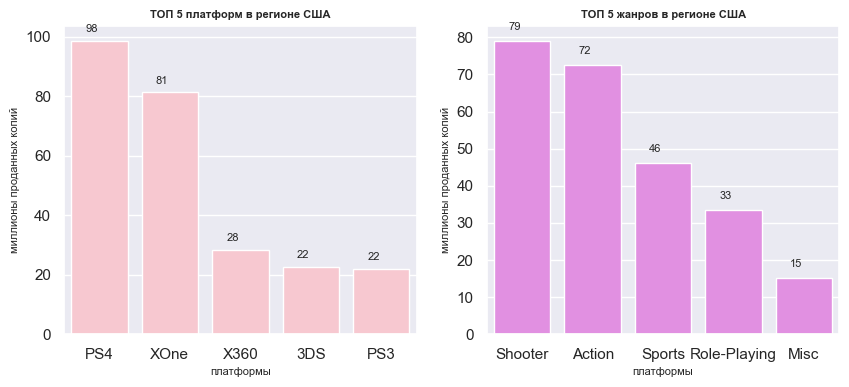

 
Влияние рейтинга ESRB на продажи


rating
E         -0.656540
M         -0.623757
E10+      -0.601785
T         -0.590155
unknown   -0.443661
dtype: float64

In [86]:
user_portrait_2(regions[0], 'США')

#### ПРОМЕЖУТОЧНЫЕ НАБЛЮДЕНИЯ

**У ПОТРЕБИТЕЛЕЙ В СЕРЕРНОЙ АМЕРИКЕ**
_______

**Самые популярные платформы последних трех лет 2014-2016**: PS4, XOne, X360, 3DS, PS3
> при этом продажи PS4 и XOne доминируют среди продаж всех остальных платформ (35% и 29% соответственно), а остальные в пятерке лучших занимают меньше 10% продаж
>
> близость продукта Microsoft к главному конкуренту от Sony в этом случае достаточно логична. XBox One отечественный для США производитель :) но интересно отметимить, что даже на родном рынке он проигрывает PS4
______

**Самые популярные жанры последних трех лет 2014-2016 в США**: Shooter, Action, Sports, Role-Playing, Misc
> при этом продажи Shooter и Action доминируют среди продаж всех остальных жанров по миллионам проданных копий (79М копий и 72М копий соответственно), следующей со значительным отставанием идет группа 3 и 4 места - Sports (46М копий) и Role-Playing (35М копий). Музыкальные игры на последнем месте показывают значительное отставание от лидеров (15М копий)
_______

**Рейтинг ESRB безусловно оказывает влияние на продажи, но разное в зависимости от его типа**
- больше всего продажи подвержены влиянию рейтинга E (Everyone, тот самый Kids to Adults) - -0.65. Это может говорить о том, что в США стремятся выбирать максимально универсальные игры, в которые могут играть и взрослые, и дети всех возрастов (предполагаю, подход про минимум заморочек внутри семьи)
- почти такой же силой влияния обладает рейтинг М (Mature, 17+) - -0.62. Игры с таким рейтингом - полноценное месилово (насилие, кровь, секс, грязные ругательства :) ). Влияние этого рейтинга может говорить о высоком проникновении приставок и бОльшем контроле над тем какой контент потребляется. Возможно, что таким образом разделяется контент для игроков-подростков и родителей/взрослых, которые играют за одной консолью. 
- на третьем месте стоит (почти такой же влиятельный как первые два рейтинга) рейтинг E10+ (Everyone 10+, все 10+) - -0.60. Такой рейтинг дается играм, в которых может быть мультяшное или фентезийное "легкое" насилие, сомнительный язык и тд, но в очень очень ограниченном количестве.
- рейтинг Т (Teen, 13+) максимально близок к E10+ и занимает четвертое место по влиятельности -0.59. Такие игры уже могут содержать насилие, кровь, сомнительный юмор, но в очень дозированном количестве.

Таким оброазом можно говорить, что пользователи в США достаточно сильно подвержены влиянию рейтингов. Скорее они выберут универсальные игры, но если нет, то будут внимательно смотреть на присвоенный рейтинг и выбирать то, что рекомендовано для определенно возраста.

#### ПОРТРЕТ ПОЛЬЗОВАТЕЛЕЙ В ЕВРОПЕ

**ЗА АКТУАЛЬНЫЙ ПЕРИОД С 2014 ПО 2016**

 
ТОП 5 платформ и доля каждой от общих продаж в регионе


,platform,sales_in_region,%_f_total_sales_in_region
3,PS4,130.04,48.04
9,XOne,46.25,17.09
2,PS3,25.54,9.44
1,PC,17.97,6.64
0,3DS,16.12,5.96


 
ТОП 5 жанров


,platform,sales_in_region
0,Action,74.68
8,Shooter,65.52
10,Sports,45.73
7,Role-Playing,28.17
6,Racing,14.13


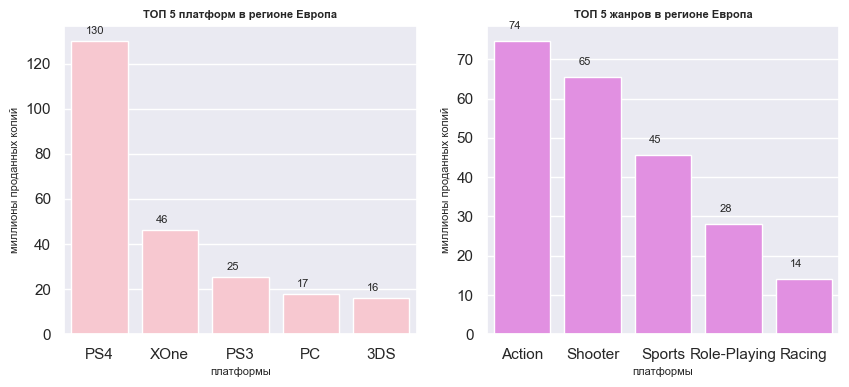

 
Влияние рейтинга ESRB на продажи


rating
E10+      -0.713158
T         -0.589766
M         -0.564732
unknown   -0.463184
E         -0.456500
dtype: float64

In [87]:
user_portrait_2(regions[1], 'Европа')

**У ПОТРЕБИТЕЛЕЙ В ЕВРОПЕ**

_______

**Самые популярные платформы последних трех лет 2014-2016**: PS4, XOne, PS3, PC, 3DS
> при этом продажи PS4 является безусловным лидером среди продаж всех остальных платформ - 48%, XOne находится на втором месте со значительным отрывом в продажах - чуть меньше 20%, а остальные в пятерке лучших занимают меньше 10% продаж 
>
> Европейский рынок очень похож на американский - платформы-любимчики почти те же, но места распределены чуть иначе. PS4 и XOne безусловные лидеры на обоих рынках. В Европе больше отдают предпочтение консолям Sony (PS3 на 3 месте, вместо X360 в Америке), 3DS - последнее место в Европе, но предпоследнее в США. Интересно то, что в Европе в ТОП5 появляется PC и на четвертом месте. Это может говорить о том, что игровая культура тут чуть более casual, люди не покупают для игр отдельное устройство, а готовы играть на том, что есть :) можно предположить, что больше пользуются Стимом и аналогами. 

_______

**Самые популярные жанры последних трех лет 2014-2016**: Action, Shooter, Sports, Role-Playing, Racing
> при этом продажи Action и Shooter доминируют среди продаж всех остальных жанров по миллионам проданных копий (74М копий и 65М копий соответственно), следующей со значительным отставанием идут - Sports (45М копий) и Role-Playing (28М копий). Гонки на последнем месте показывают значительное отставание от лидеров (14М копий)
>
> За исключением последних мест в топе рынок Европы и США в разрезе любимых жанров очень похож. В Европе отдают чуть большее предпочтение Action жанрам, чем Shooter (это можно объяснить культурными различиями и в частности отношением к оружию: американский пользоатель более брутален)
_______

**Рейтинг ESRB безусловно оказывает влияние на продажи, но разное в зависимости от его типа**
- рейтинг E10+ (Everyone 10+, все 10+) оказывает наиболее сильное влияние на продажи - -0.71. Можно предположить, что на европейском рынке особенно важны игры, в которые могут играть все, а к гаджетам детей подпускают позднее, чем в США
- значительно меньшее и скорее умеренное по силе влияние на покупки оказывает рейтинг Т (Teen, 13+) - -0.58
- рейтинг М (Mature, 17+) оказывает умеренное влияние - -0.56
- рейтинг E (Everyone, Kids to Adults) оказывает выраженное умеренное влияние - -0.45

В целом можно говорить о том, что европейский рынок менее подвержен влиянию рейтингов, чем североамериканский. 

#### ПОРТРЕТ ПОЛЬЗОВАТЕЛЕЙ В ЯПОНИИ

**ЗА АКТУАЛЬНЫЙ ПЕРИОД С 2014 ПО 2016**

 
ТОП 5 платформ и доля каждой от общих продаж в регионе


,platform,sales_in_region,%_f_total_sales_in_region
0,3DS,44.24,47.52
3,PS4,15.02,16.13
5,PSV,14.54,15.62
2,PS3,11.22,12.05
7,WiiU,7.31,7.85


 
ТОП 5 жанров


,platform,sales_in_region
7,Role-Playing,31.16
0,Action,29.58
2,Fighting,6.37
3,Misc,5.61
8,Shooter,4.87


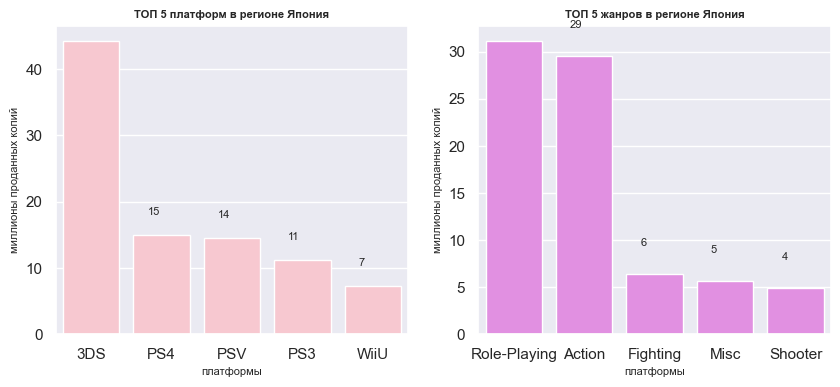

 
Влияние рейтинга ESRB на продажи


rating
unknown   -0.414752
M         -0.365989
E         -0.326959
T         -0.269943
E10+      -0.192870
dtype: float64

In [88]:
user_portrait_2(regions[2], 'Япония')

**У ПОТРЕБИТЕЛЕЙ В ЯПОНИИ** заметно и ожидаемо отличаются вкусы и поведенческие паттерны от Европы и США

_______

**Самые популярные платформы последних трех лет 2014-2016**: 3DS, PS4, PSV, PS3, WiiU
> при этом 3DS является безусловным лидером среди продаж всех остальных платформ - 47%, PS4 находится на втором месте со значительным отрывом в продажах - 16%, третье место по доле у PSV - чуть больше 15%, четвертое место у PS3 с 12%, пятое место WiiU - чуть меньше 8%
>
> Таким образом, Япония - единственный рынок, где PS4 не просто не является лидером, а имеет долю меньше 20%. 
>
> Также это единсвенный рынок, где на первом и на третьем месте находятся носимые консоли (а PSV вообще впервые в топе). Япония любит инновации :) 
>
> Все участники ТОПа - японского происхождения, никакого Microsoft :)

_______


 

**Самые популярные жанры последних трех лет 2014-2016**: Role-Playing, Action, Fighting, Misc, Shooter
> при этом продажи Role-Playing и Action разгромно доминируют среди продаж всех остальных жанров по миллионам проданных копий (31М копий и 30М копий соответственно). Остальные игры в ТОПе имеют меньше 5-6М продаж.
> 
> главный жанр Японии - ролевые игры (такие как моя любимая Zelda, Skyrim, Oblivion и тд) - в США и Европе но находится только на 4 позиции. И это первый раз, когда жанр Action занимает второе место, хотя и с очень небольшим отрывом
>
> В топе первый раз появляется жанр Fighting. Здесь можно предположить, что в этом жанре удобно играть на носимых консолях + нельзя забывать о культурном аспекте и популярности в Японии традиционнх боев
>
> Также стоит отметить, что жанр Shooter находится на последней строчке (в США на первой!). На мой взгляд его сравнительная непопулярность также связана с культурными различиями и большей традиционностью общества (и игрового рынка)


Итого, в данном случае различия связаны с культурными особенностями Японии: любовь к национальному продукту (как платформам, так и жанрам, и не только в играх) очень сильна, влияние западных трендов прослеживается (шуттеры все-таки попали в топ), то идет с большим запозданием.


_______

**Рейтинг ESRB оказывает весьма умеренное влияние на продажи**
- рейтинг М (Mature, 17+) является самым влиятельным на всем временном промежутке, но его влияние на покупки очень умеренное - -0.36
- рейтинг E (Everyone, Kids to Adults) оказывает еще более умеренное влияние - -0.32
- рейтинг Т (Teen, 13+) оказвает скорее слабое влияние на покупки - -0.26
- рейтинг E10+ (Everyone 10+, все 10+) оказывает самое слабое влияние -  -0.19

В целом можно говорить о том, что японский рынок наименее подвержен влиянию рейтингов, чем все остальные.

<a id="gip"></a>
## ПРОВЕРКА ГИПОТЕЗ

В рамках задачи мне необходимо проверить 2 гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

>Сначала немного пояснений о методологии исследования
>- **Как я формулирую нулевую и альтернативную гипотезы**
> 
> Нулевыми в обоих случаях будут гипотезы тождества, потому что тождество является базовым предположением, что никакого статистически значимого различия между двумя группами нет. Другими словами, нулевая гипотеза предполагает, что любое различие между выборками или переменными происходит случайно, а не по настоящей причине.
>
> Формулирование нулевой гипотезы как тождества позволит проверить, является ли наблюдаемое различие статистически значимым, то есть существенно отличающимся от того, что можно было бы ожидать при случайном распределении. Если различие статистически значимо, то нулевая гипотеза будет отвергнута в пользу альтернативной , которая предполагает наличие реального различия между группами.
>
>- **Какой критерий я применю для проверки гипотез и почему**
>
> для проверки гипотез о равенстве средних двух генеральных совокупностей обычно пользуются тестом Стьюдента (scipy.stats.ttest_ind). Но, прежде чем его применять, необходимо проверить предположения о нормальности распределения данных и равенстве дисперсий в двух выборках для каждой из гипотез. Если это предположение не оправдается, нужно будет использовать другой метод проверки гипотез - критерий Манна-Уитни.
>

*Для работы буду использовать датасет на основе a_data, очищенный от пропусков в оценке пользователей*

In [89]:
a_data_clean_user_score = a_data.dropna(subset=['user_score'])
a_data_clean_user_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 42 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             888 non-null    object 
 1   platform         888 non-null    object 
 2   year_of_release  888 non-null    float64
 3   genre            888 non-null    object 
 4   na_sales         888 non-null    float64
 5   eu_sales         888 non-null    float64
 6   jp_sales         888 non-null    float64
 7   other_sales      888 non-null    float64
 8   critic_score     704 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           888 non-null    object 
 11  total_sales      888 non-null    float64
dtypes: float64(8), object(4)
memory usage: 90.2+ KB


#### ПРОВЕРКА ГИПОТЕЗЫ СРЕДНИЕ ПОЛЬЗОВАТЕЛЬСКИЕ РЕЙТИНГИ ПЛАТФОРМ XBOX ONE И PC ОДИНАКОВЫЕ

В первую очередь сформирую выбоки для каждой из платформ.

In [90]:
XOne = a_data_clean_user_score[(a_data['platform']=='XOne')]['user_score']
PC = a_data_clean_user_score[(a_data_clean_user_score['platform']=='PC')]['user_score']

Далее проверю распределение на нормальность

In [91]:
# для удобства напишу функцию, так нужно будет проверить еще одну гипотезу :)
def graf (plt1, plt2, plt1_name, plt2_name):
    sns.set(style="darkgrid")
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data=plt1, kde=True, color="skyblue", ax=axs[0])
    axs[0].set_title(f'распределение оценок для платформы {plt1_name}', fontsize=8, weight='bold', ha='center')
    axs[0].set_xlabel('оценки пользователей', fontsize=8)
    axs[0].set_ylabel('')
    sns.histplot(data=plt2, kde=True, color="olive", ax=axs[1])
    axs[1].set_title(f'распределение оценок для платформы {plt2_name}', fontsize=8, weight='bold', ha='center')
    axs[1].set_xlabel('оценки пользователей', fontsize=8)
    axs[1].set_ylabel('')
    fig.suptitle('Распределение оценок пользователей')
    plt.show()
    ;

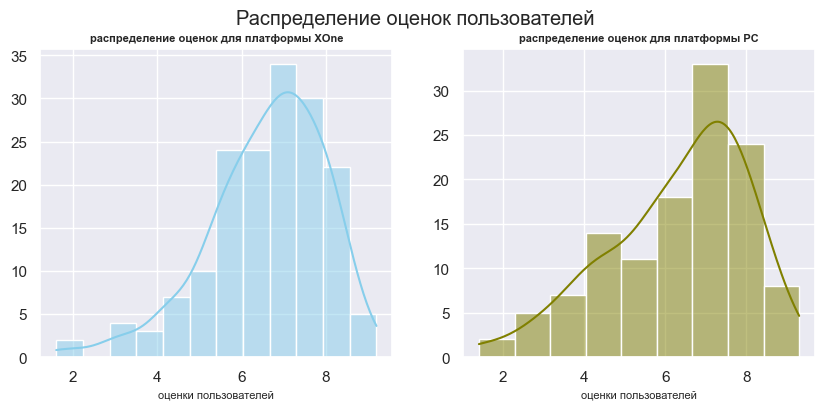

In [92]:
graf(XOne, PC, 'XOne', 'PC')

**Графики не выглядят как нормально распределенные**. Если для платформы XBox One распределение еще стремится к нормальному, то в случае с PC оно явно скошено вправо.

Тем не менее, для точности проведу дополнительную проверку на нормальность распределения данных с помощью теста Шапиро-Уилка

In [93]:
# для удобства напишу функцию

# нулевая гипотеза этого теста - распределение нормальное
# альтернативная гипотеза - распределение не нормально

def test_shapiro (plt):
    alpha = 0.05

    results = st.shapiro(plt)
    p_value = results[1]

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

In [94]:
test_shapiro(XOne)

p-значение:  2.5650208044680767e-05
Отвергаем нулевую гипотезу: распределение не нормально


In [95]:
test_shapiro(PC)

p-значение:  0.00017992201901506633
Отвергаем нулевую гипотезу: распределение не нормально


**Распределение обоих выборок не нормальное**.

Проверю стандартные отклонения и дисперсии:

In [96]:
# для удобства напишу функцию
def stats (plt1, plt2, plt1_name, plt2_name):
    std_1 = np.std(plt1)
    std_2 = np.std(plt2)
    var_1 = np.var(plt1)
    var_2 = np.var(plt2)

    print(f"Стандартное отклонение для платформы {plt1_name}:", std_1)
    print(f"Стандартное отклонение для платформы {plt2_name}:", std_2)
    print(" ")
    print(f"Дисперсия для платформы {plt1_name}:", var_1)
    print(f"Дисперсия для платформы {plt2_name}:", var_2)

In [97]:
stats (XOne, PC, 'XOne', 'PC')

Стандартное отклонение для платформы XOne: 1.3709653553280048
Стандартное отклонение для платформы PC: 1.6962825123577492
 
Дисперсия для платформы XOne: 1.8795460055096425
Дисперсия для платформы PC: 2.8773743617307175


**ВЫБОР МЕТОДА ПРОВЕРКИ ГИПОТЕЗЫ**

Проверка данных показывает, что распределение обоих выборок не норамльное, стандарнтное отклонение незначительно, но различается, а дисперсия выборок различается сильно. В таком случае более правильно будет применить критерий Манна-Уитни для провеки гипотез, который не требует предположения о нормальности распределения данных.

**ФОРМУЛИРУЮ ГИПОТЕЗЫ**

H₀ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H₁ Средние пользовательские рейтинги платформ Xbox One и PC различные

**За уровень критической значимости в данном случае принимаю alpha = 0.05**

In [98]:
alpha = 0.05

results = st.mannwhitneyu(XOne, PC)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Средние значения в двух выборках различны (отвергаем нулевую гипотезу)')
else:
    print('Средние значения в двух выборках не отличаются (не отвергаем нулевую гипотезу)')

p-значение:  0.27752869727762175
Средние значения в двух выборках не отличаются (не отвергаем нулевую гипотезу)


ВЫВОД - **СРЕДНИЕ ПОЛЬЗОВАТЕЛЬСКИЕ РЕЙТИНГИ ПЛАТФОРМ XBOX ONE И PC ОДИНАКОВЫ**

#### ПРОВЕРКА ГИПОТЕЗЫ СРЕДНИЕ ПОЛЬЗОВАТЕЛЬСКИЕ РЕЙТИНГИ ЖАНРОВ ACTION И SPORTS РАЗНЫЕ

Сформирую выборки для каждого жанра

In [99]:
Action = a_data_clean_user_score[(a_data['genre']=='Action')]['user_score']
Sports = a_data_clean_user_score[(a_data_clean_user_score['genre']=='Sports')]['user_score']

Далее проверю распределение на нормальность

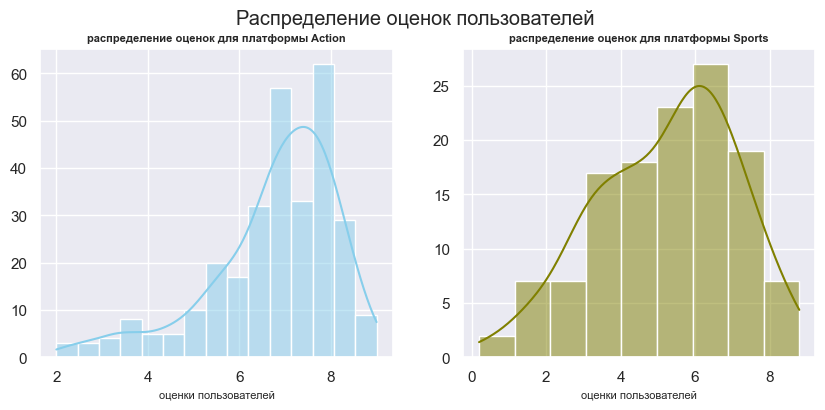

In [100]:
graf(Action, Sports, 'Action', 'Sports')

**Распределение снова не похоже на нормальное**, в обоих выборках оно заметно скошено вправо. Снова проведу тест Шапиро-Уилка, чтобы быть уверенныой в своем выводе

In [101]:
test_shapiro(Action)

p-значение:  1.3703006828194586e-12
Отвергаем нулевую гипотезу: распределение не нормально


In [102]:
test_shapiro(Sports)

p-значение:  0.03466314077377319
Отвергаем нулевую гипотезу: распределение не нормально


**Распределение обоих выборок не нормальное**.

Проверю стандартные отклонения и дисперсии:

In [103]:
stats (Action, Sports, 'Action', 'Sports')

Стандартное отклонение для платформы Action: 1.3755306180435933
Стандартное отклонение для платформы Sports: 1.8492802815352567
 
Дисперсия для платформы Action: 1.89208448117539
Дисперсия для платформы Sports: 3.4198375596751185


**ВЫБОР МЕТОДА ПРОВЕРКИ ГИПОТЕЗЫ**

Проверка данных показывает, что распределение обоих выборок ненорамльное, стандарнтное отклонение заметно различается, а дисперсия выборок различается сильно. В таком случае снова будет более правильно применить критерий Манна-Уитни для провеки гипотез, который не требует предположения о нормальности распределения данных.

**ФОРМУЛИРУЮ ГИПОТЕЗЫ**

H₀ Средние пользовательские рейтинги жанров Action и Sports одинаковые

H₁ Средние пользовательские рейтинги жанров Action и Sports разные

**За уровень критической значимости в данном случае принимаю alpha = 0.05**

In [104]:
alpha = 0.05

results = st.mannwhitneyu(Action, Sports)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Средние значения в двух выборках различны (отвергаем нулевую гипотезу)')
else:
    print('Средние значения в двух выборках не отличаются (не отвергаем нулевую гипотезу)')

p-значение:  1.2166879280294303e-16
Средние значения в двух выборках различны (отвергаем нулевую гипотезу)


ВЫВОД - **СРЕДНИЕ ПОЛЬЗОВАТЕЛЬСКИЕ РЕЙТИНГИ ЖАНРОВ ACTION И SPORTS РАЗНЫЕ**

<a id="results"></a>
## ЗАКОНОМЕРНОСТИ, ОПРЕДЕЛЯЮЩИЕ УСПЕШНУЮ ИГРУ И РЕКОМЕНДАЦИИ ПО ПЛАНИРОВАНИЮ РЕКЛАМНЫХ КАМПАНИЙ НА 2017 ГОД

**СИТУАЦИЯ НА РЫНКЕ ИГРОВЫХ КОНСОЛЕЙ**

В рамках исследования мной был проведен анализ по всему массиву имеющихся данных с 1980 по 2016, поэтому можно сделать вывод о состоянии рынка игровых консолей в целом:
- жизненный цикл рынка можно разделить на два четко очерченых этапа:
    - **с 1980 по 2008 год** - это рост рынка, развитие технологий, выход новых платформ и ежегодный рост количества выпускаемых игр вплоть до пика, который приходится на 2008 (выпущено 1441 игры) 
    - **с 2008 по 2016 год** - после этого подъема рынок показывает стагнацию, количество выпускаемых игр уменьшается (но более плавно, чем увеличивалось) и к 2016 он находится в своей нижней точке. Стагнация связана с развитием мобильных игр, активно стартовавшем как раз в 2008 году
- время жизни игровых платформ составляет 8-12 лет, по истечении которых продажи переключаются на более новые модели 

**САМЫЕ ПЕРСПЕКТИВНЫЕ ПЛАТФОРМЫ**

**Основной принцип**: пользователи стремятся обладать последней или предпоследней моделью консоли любимого производителя

В разрезе 3-летней перспективы главными платфомами являются:
1. **PlayStation 4** 
2. **Xbox One**
3. **Nintendo 3DS**
4. **PlayStation 3**
5. **Xbox 360**
6. **Nintendo WiiU**
7. **Microsoft PC**
8. **PlayStation Vita**
9. **Nintendo Wii**
10. **PlayStation Portable**

**ВЛИЯНИЕ ОЦЕНОК КРИТИКОВ И ПОЛЬЗОВАТЕЛЕЙ НА ПРОДАЖИ ИГР ДЛЯ ПЕРСПЕКТИВНЫХ ПЛАТФОРМ**

**Короткий ответ** - оценки критиков значительно важнее для пользователей, чем оценки других игроков.

При этом, если мы говорим о PlayStation 4 и XBox One, то оценки пользователей практически не оказывают влияние на продажи, а оценки критиков имеют умеренное влияние.

В ситуации с более нишевыми Nintendo 3DS и Nintendo WiiU оценки пользователей и критиков имеют одинаковое умеренное влияние. Платформы Nintendo стоят отдельно, так как на них скорее всего выпускается гораздо меньше игр, поэтому:
- с одной стороны, критики наверняка не так охотно пишут на них обзоры
- у пользователей скорее всего сильное комьюнити, и они с удовольствием пишут обзоры

**Носимая консоль PlayStation Vita - самый нишевый продукт** Влияние как оценок критиков, так и оценок пользователей здесь крайне мало. Это объясняется спецификой развития самой платформы, для которой выпускалось много инди. Инди-игры - это, можно сказать, авторские высказывания, и только на личном опыте можно понять зайдет тебе игра или нет.

**САМЫЕ ПЕРСПЕКТИВНЫЕ ЖАНРЫ ИГР**

**Жанры, на которых мы точно заработаем** (с медианой на среднем уровне относительно других и небольшими выбросами):
1. Fighting - медиана близка к среднему
2. Sports - медиана чуть ниже среднего
3. Role-Playing - медиана чуть ниже среднего
4. Music - медиана чуть ниже среднего
5. Racing - медиана чуть ниже среднего

Все они имеют достаточно близкую к среднему медиану, относительно невысокие выборсы, а также 4 из 5 входят в топ по количеству выпускаемых игр и по совокупным продажам. Другими словами, эти жанры популярны, в них выпускается достаточное количество игр (так жанр Platform не берем именно по этому признаку), но при этом их продажи сравнительно консистентны.

**Жанры, в которые мы инвестируем, надеясь попасть в звезды 2017 года** (с медианой на высоком уровне относительно других и/или значительными выбросами):
- Shooter
- Action

Здесь, хотя эти жанры находятся в ТОПах по кличеству и по продажам, у Shooter-ов медиана очень высокая и выбросы самые большие, а у жанра Action хотя и среднее значение медианы, но тоже очень значительные выбросы. В обоих жанрах выпускается много игр, но очевидно, что в обоих бывают игры-звезды, которые делают кассу, и проходные пустышки. Поэтому закупать игры нужно ориентируясь на дополнительные исследования (прогнозы критиков, анализ пользовательского сообщества (что больше ждут), экспертный анализ)

**При этом можно выделить безусловные жанры-"аутсайдеры"**:
- игры в жанре пазл находятся на последней строчке и по продажам и по количеству выпущенных игр (12 место)
- рядом с ними стоят игры в жанре стратегии - предпоследнее место по продажам и по выпуску игр (11 место)
___

**!!! ВАЖНО ПОМНИТЬ**, что разные платформы и жанры актуальны для разных стран, поэтому нужно ориентироваться при составлении плана продаж и рекламных компаний не только на глобальные тренды, но и на региональные особенности

**ПОРТРЕТЫ ПОЛЬЗОВАТЕЛЕЙ ПО РЕГИОНАМ**

**Основной принцип** - есть значительные различия между пользователями в Японии и пользователями в США и Европе. При создании рекламных кампаний обязательно нужно учитывать региональные различия.

**США**
- Самые популярные **платформы** последних трех лет 2014-2016 в США: PS4, XOne, X360, 3DS, PS3
- Самые популярные **жанры** последних трех лет 2014-2016 в США**: Shooter, Action, Sports, Role-Playing, Misc
- **Рейтинги ESRB** оказывают на пользователей из США самое значительное влияние среди всех регионов

**ЕВРОПА**
- Самые популярные **платформы** последних трех лет 2014-2016 в Европе: PS4, XOne, PS3, PC, 3DS
- Самые популярные **жанры** последних трех лет 2014-2016 в Европе: Action, Shooter, Sports, Role-Playing, Racing
- **Рейтинги ESRB** оказывают на пользователей из Европы меньшее влияние, чем на пользователей из США

**ЯПОНИЯ**
- Самые популярные **платформы** последних трех лет 2014-2016 в Японии: 3DS, PS4, PSV, PS3, WiiU
- Самые популярные **жанры** последних трех лет 2014-2016 в Японии: Role-Playing, Action, Fighting, Misc, Shooter
- **Рейтинги ESRB** оказывают на пользователей из Японии самое незначительное влияние среди всех регионов

>Отдельно хочу подчеркнуть еще раз особенности рынка Японии: 
>
>- любовь к национальному продукту (как платформам, так и жанрам, и не только в играх) очень сильна, влияние западных трендов прослеживается (шуттеры все-таки попали в топ), то идет с большим запозданием
>- консервативность и "тадиционность" с точки зрения используемых платформ и жанровых предпочтений
___

**РЕЗЮМЕ ПО САМЫМ ПЕРСПЕКТИВНЫМ ИГРАМ**

В 2017 году стоит делать ставку:
- на североамериканском и европейском рынках - на Shooter и Action для PS4 и XOne
- на японском рынке - на Role-Playing и Action для 3DS и PS4 
- для североамериканского рынка рейтинги важны и стоит делать ставку на Е, М и Е10+, они почти одинаково влиятельны
- для европейского рынка рейтинги умеренно важны, но стоит обратить внимание на Е10+, Т и М (в порядке убывания влиятельности
- для японского рынка стоит обратить внимание только на рейтинг М и Е, но в целом рейтинги не оказывают заметного влияния

___

**В рамках исследования я проверила две рабочие гипотезы**:
1. О средних пользовательских рейтингах платформ Xbox One и PC. **ВЫВОД**: они одинаковые
2. О средних пользовательских рейтингах жанров Action и Sports. **ВЫВОД**: они разные